<a href="https://colab.research.google.com/github/elangptra/music_classification/blob/main/Klasifikasi_genre_musik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:16<00:00, 79.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
import shutil

# Path folder yang ingin dihapus
folder_path = "/content/GTZAN/genres_augmented"

# Hapus folder dan seluruh isinya
try:
    shutil.rmtree(folder_path)
    print(f"Folder {folder_path} berhasil dihapus.")
except FileNotFoundError:
    print(f"Folder {folder_path} tidak ditemukan.")
except Exception as e:
    print(f"Terjadi kesalahan: {e}")

Folder /content/GTZAN/genres_augmented berhasil dihapus.


In [ ]:
import shutil

# Path sumber dari `kagglehub`
source_path = "/content/GTZAN/Data/genres_original"
target_path = "/content/GTZAN"

# Pindahkan semua file
shutil.move(source_path, target_path)

print(f"Dataset berhasil dipindahkan ke {target_path}")

Dataset berhasil dipindahkan ke /content/GTZAN


In [ ]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import base64
from IPython.display import HTML
from IPython.display import FileLink

Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.model_selection as skms

In [ ]:
import keras
from keras import models
from keras import layers
from tensorflow import keras
from warnings import filterwarnings

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/dataset/hiphop/hiphop.00013.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00007.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00006.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00012.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00004.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00009.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00003.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00011.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00008.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00010.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00005.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00000.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00002.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00001.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00018.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00023.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00016.wav
/content/drive/MyDrive/dataset/hiphop/hiphop.00027.wav
/content/d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preparation

In [ ]:
general_path = '/content/drive/MyDrive/dataset'
print(list(os.listdir(f'{general_path}')))

['hiphop', 'country', 'classical', 'rock', 'pop', 'jazz', 'reggae', 'disco', 'blues', 'metal', 'genres_augmented']


In [ ]:
import os
import numpy as np
import librosa
from scipy.signal import fftconvolve
import soundfile as sf

# Path ke folder dataset
input_dir = '/content/drive/MyDrive/dataset'
output_dir = '/content/drive/MyDrive/dataset/genres_augmented'

# Validasi folder input dan buat folder output
if not os.path.exists(input_dir):
    raise FileNotFoundError(f"Folder input {input_dir} tidak ditemukan.")
os.makedirs(output_dir, exist_ok=True)

# Fungsi augmentasi
def pitch_shift_positive(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def pitch_shift_negative(data, sr, n_steps=-2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def add_reverb(data, sr, ir_file=None):
    """
    Menambahkan efek reverb ke sinyal audio menggunakan impulse response (IR).
    :param data: Sinyal audio asli.
    :param sr: Sample rate dari audio.
    :param ir_file: Path ke file impulse response (IR). Jika None, gunakan IR default.
    :return: Sinyal audio dengan efek reverb.
    """
    if ir_file is None:
        # Gunakan impulse response default (contoh IR pendek)
        ir = np.zeros(int(sr * 0.5))  # Durasi IR 0.5 detik
        ir[0] = 1.0  # Impuls pertama (direct sound)
        ir[int(sr * 0.1)] = 0.6  # Pantulan pertama setelah 0.1 detik
        ir[int(sr * 0.2)] = 0.3  # Pantulan kedua setelah 0.2 detik
    else:
        # Muat file IR eksternal jika diberikan
        ir, _ = librosa.load(ir_file, sr=sr, mono=True)

    # Normalisasi IR agar tidak menyebabkan clipping
    ir = ir / np.max(np.abs(ir))

    # Convolve audio dengan IR untuk menambahkan reverb
    reverb_data = fftconvolve(data, ir, mode='full')

    # Potong hasil convolution agar sesuai dengan panjang audio asli
    reverb_data = reverb_data[:len(data)]

    # Normalisasi hasil akhir agar tidak overamplifikasi
    reverb_data = reverb_data / np.max(np.abs(reverb_data))

    return reverb_data

# Proses augmentasi
genres = os.listdir(input_dir)
for genre in genres:
    genre_dir = os.path.join(input_dir, genre)
    if os.path.isdir(genre_dir):
        genre_output_dir = os.path.join(output_dir, genre)
        os.makedirs(genre_output_dir, exist_ok=True)

        for filename in os.listdir(genre_dir):
            if filename.endswith('.wav'):
                input_path = os.path.join(genre_dir, filename)
                try:
                    data, sr = librosa.load(input_path, sr=None)
                except Exception as e:
                    print(f"Kesalahan saat memproses {input_path}: {e}")
                    continue

                # Augmentasi
                augmented_data = {
                    'original': data,
                    'pitch_positive': pitch_shift_positive(data, sr),
                    'pitch_negative': pitch_shift_negative(data, sr),
                    'reverb': add_reverb(data, sr),  # Tambahkan efek reverb
                }

                # Simpan hasil augmentasi
                for aug_type, aug_data in augmented_data.items():
                    output_filename = f"{os.path.splitext(filename)[0]}_{aug_type}.wav"
                    output_path = os.path.join(genre_output_dir, output_filename)
                    sf.write(output_path, aug_data, sr)
                    print(f"File {aug_type} disimpan ke {output_path}")

print("Proses augmentasi selesai.")

File original disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00013_original.wav
File pitch_positive disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00013_pitch_positive.wav
File pitch_negative disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00013_pitch_negative.wav
File reverb disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00013_reverb.wav
File original disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00007_original.wav
File pitch_positive disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00007_pitch_positive.wav
File pitch_negative disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00007_pitch_negative.wav
File reverb disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00007_reverb.wav
File original disimpan ke /content/drive/MyDrive/dataset/genres_augmented/hiphop/hiphop.00006_original.w

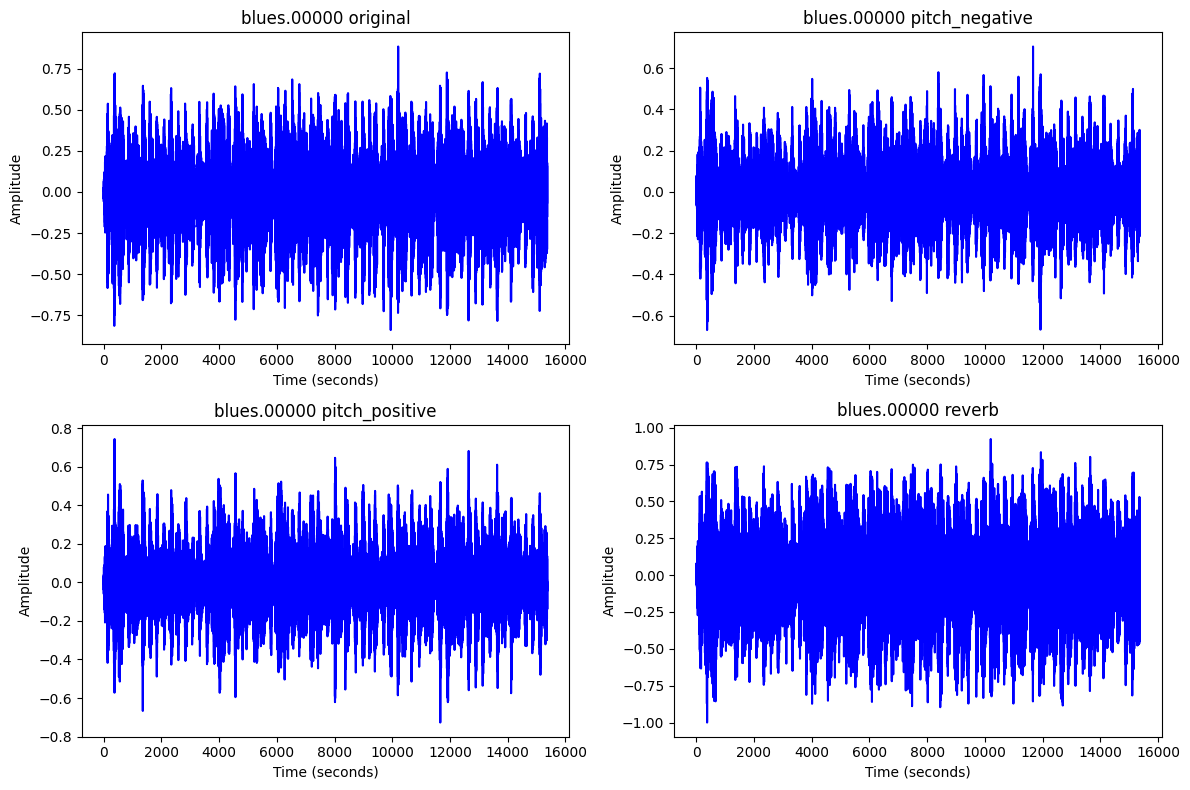

In [ ]:
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

# File audio yang akan divisualisasikan
audio_files = [
    '/content/drive/MyDrive/dataset/genres_augmented/blues/blues.00000_original.wav',
    '/content/drive/MyDrive/dataset/genres_augmented/blues/blues.00000_pitch_negative.wav',
    '/content/drive/MyDrive/dataset/genres_augmented/blues/blues.00000_pitch_positive.wav',
    '/content/drive/MyDrive/dataset/genres_augmented/blues/blues.00000_reverb.wav'
]

# Judul untuk setiap file
titles = [
    "blues.00000 original",
    "blues.00000 pitch_negative",
    "blues.00000 pitch_positive",
    "blues.00000 reverb"
]

# Membuat plot
plt.figure(figsize=(12, 8))
for i, (file, title) in enumerate(zip(audio_files, titles), 1):
    try:
        # Membaca file audio
        data, sr = librosa.load(file, sr=None)
        time = librosa.times_like(data, sr=sr)

        # Subplot untuk waveform
        plt.subplot(2, 2, i)
        plt.plot(time, data, color='blue')
        plt.title(title)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
    except Exception as e:
        print(f"Error processing file {file}: {e}")

plt.show()

Dimensi MFCC: (13, 1293)


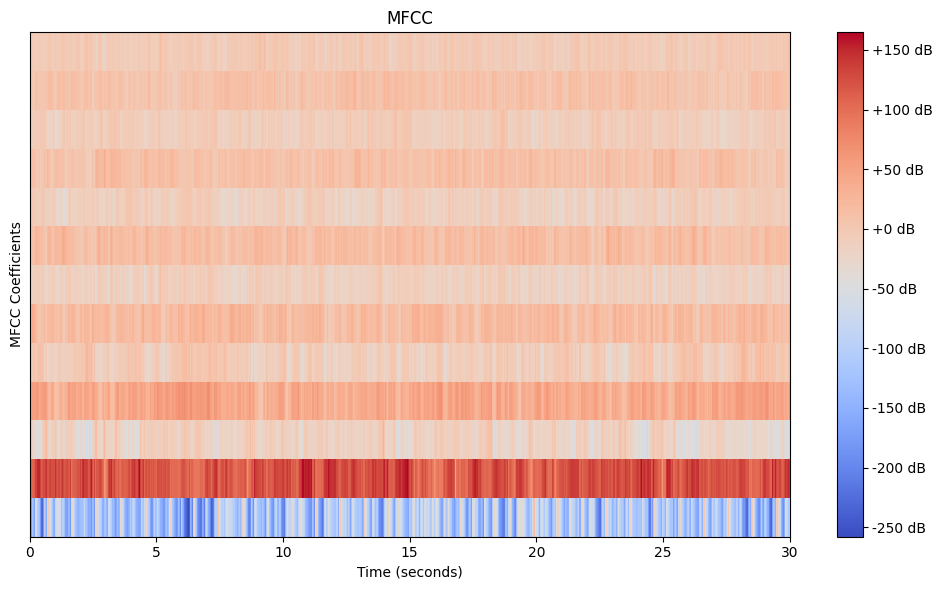

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Pilih salah satu file audio
audio_file = '/content/drive/MyDrive/dataset/genres_augmented/blues/blues.00000_original.wav'

# Membaca file audio
data, sr = librosa.load(audio_file, sr=None)

# Ekstraksi fitur MFCC
n_mfcc = 13  # Jumlah koefisien MFCC yang akan diekstrak
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)

# Menampilkan dimensi MFCC
print("Dimensi MFCC:", mfcc.shape)

# Visualisasi MFCC
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time (seconds)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

Segmentasi 5 detik menghasilkan 6 segmen penuh
Dimensi MFCC segmen ke-1 (5 detik): (13, 216)


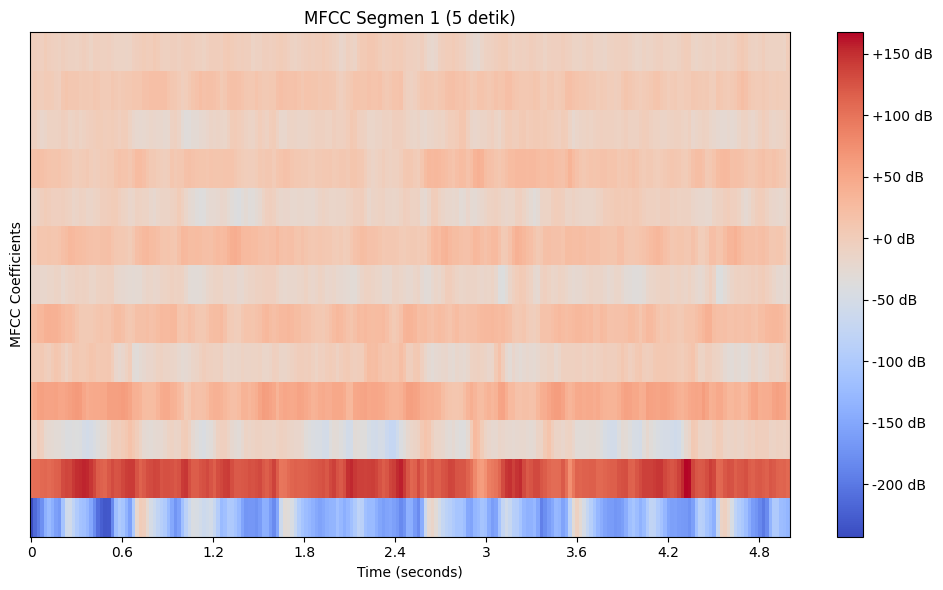

Dimensi MFCC segmen ke-2 (5 detik): (13, 216)


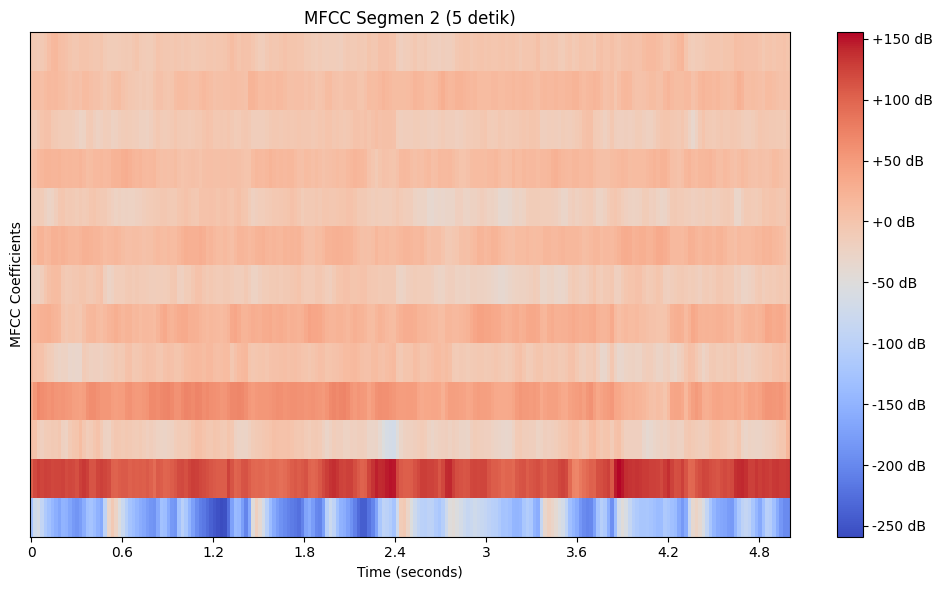

Dimensi MFCC segmen ke-3 (5 detik): (13, 216)


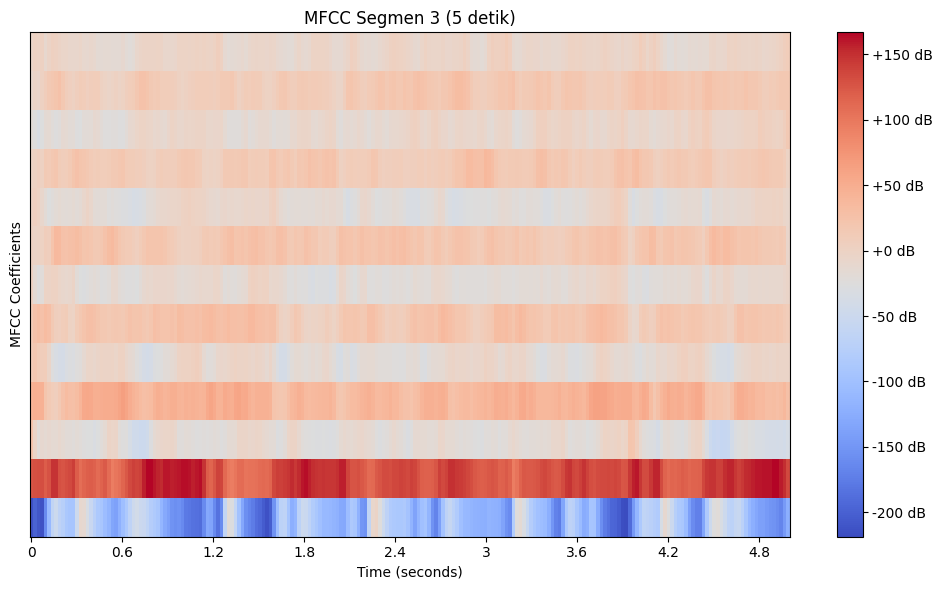

Dimensi MFCC segmen ke-4 (5 detik): (13, 216)


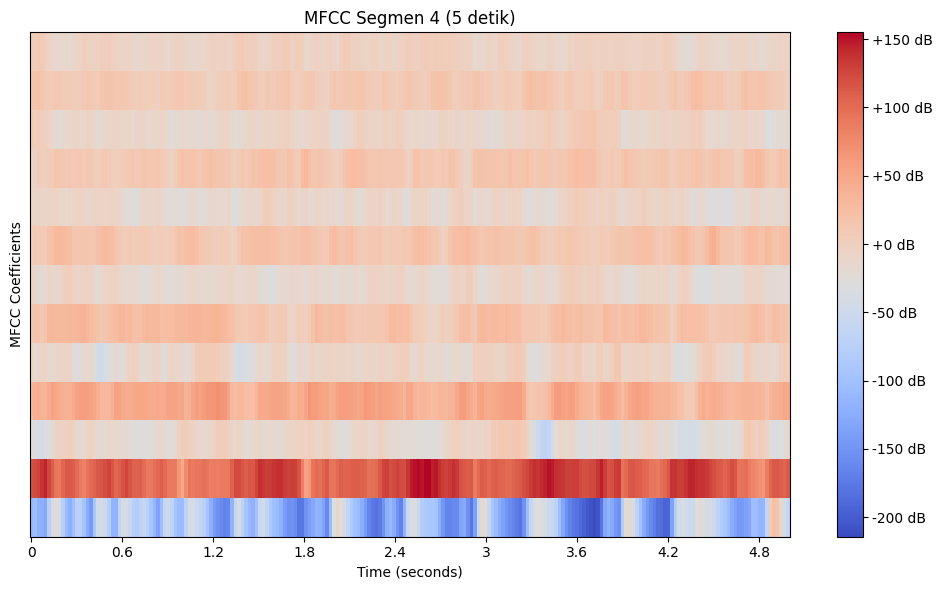

Dimensi MFCC segmen ke-5 (5 detik): (13, 216)


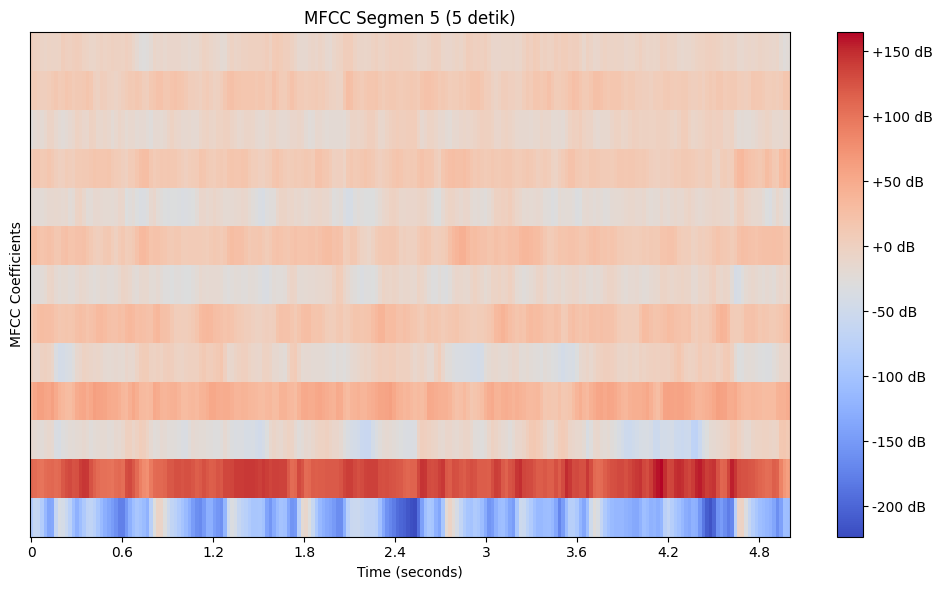

Dimensi MFCC segmen ke-6 (5 detik): (13, 216)


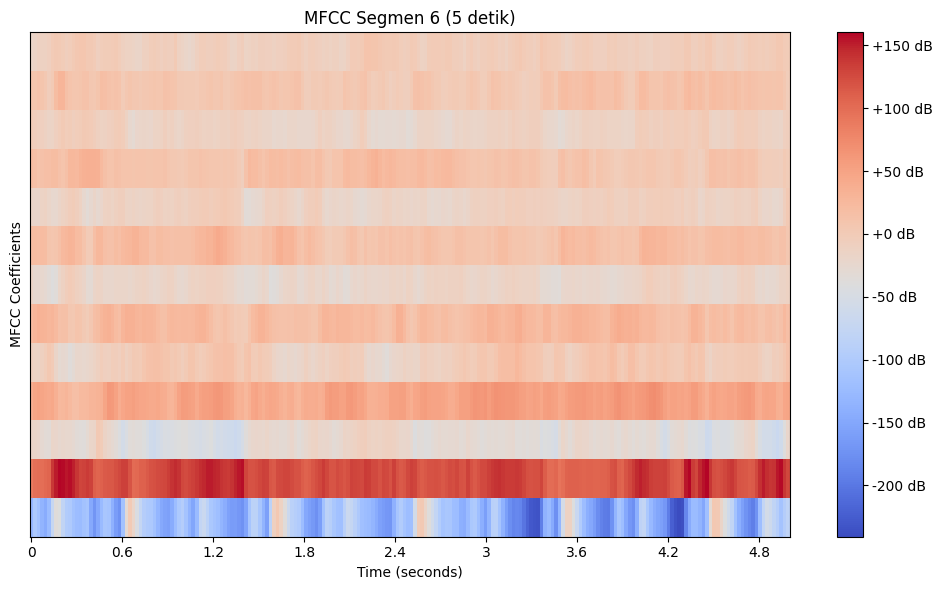

Segmentasi 10 detik menghasilkan 3 segmen penuh
Dimensi MFCC segmen ke-1 (10 detik): (13, 431)


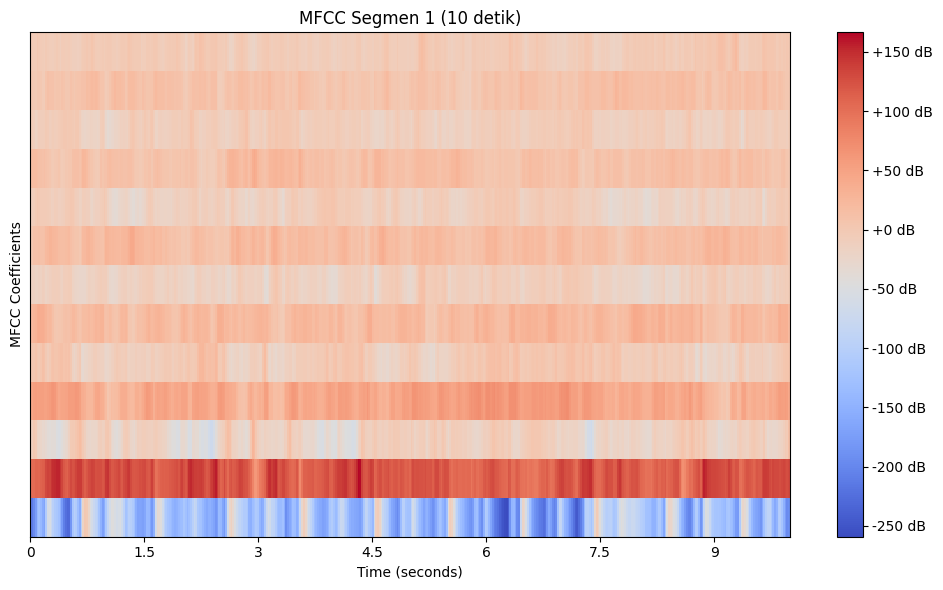

Dimensi MFCC segmen ke-2 (10 detik): (13, 431)


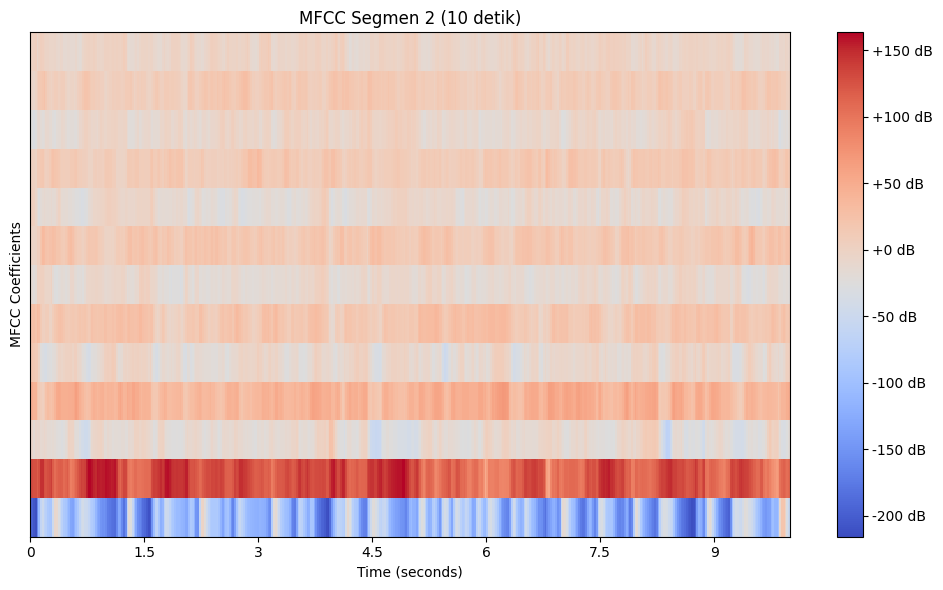

Dimensi MFCC segmen ke-3 (10 detik): (13, 431)


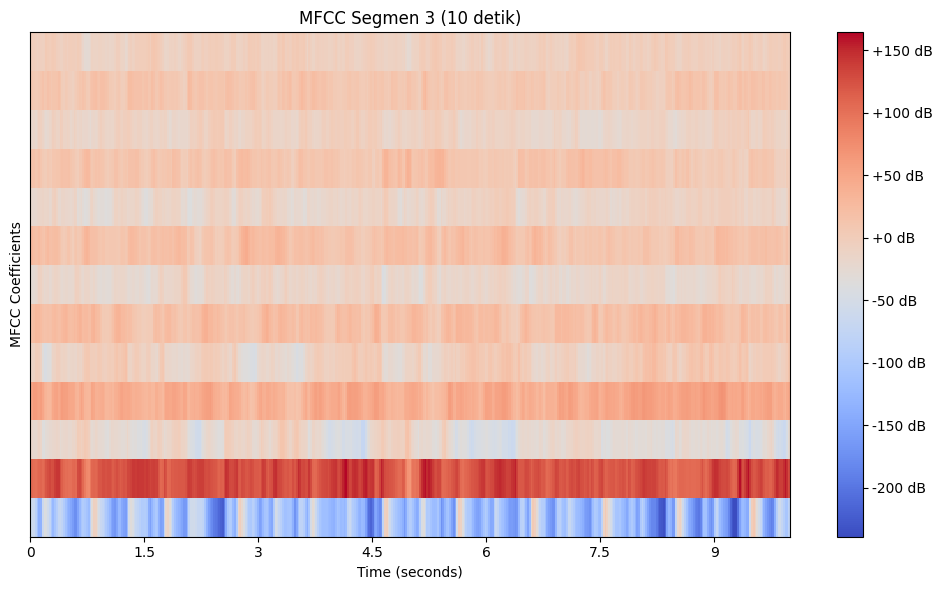

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Pilih salah satu file audio
audio_file = '/content/drive/MyDrive/dataset/genres_augmented/blues/blues.00000_original.wav'

# Membaca file audio
data, sr = librosa.load(audio_file, sr=None)

# Fungsi untuk membagi audio menjadi segmen
def segment_audio(data, sr, segment_duration):
    segment_length = int(segment_duration * sr)  # Panjang segmen dalam sampel
    return [data[i:i + segment_length] for i in range(0, len(data), segment_length)]

# Segmentasi audio dengan durasi 5 detik
segments_5s = [seg for seg in segment_audio(data, sr, segment_duration=5) if len(seg) == sr * 5]

# Segmentasi audio dengan durasi 10 detik
segments_10s = [seg for seg in segment_audio(data, sr, segment_duration=10) if len(seg) == sr * 10]

# n_fft dan hop_length untuk ekstraksi MFCC
n_fft = 2048
hop_length = 512

# Proses dan visualisasi MFCC untuk setiap segmen 5 detik
print(f"Segmentasi 5 detik menghasilkan {len(segments_5s)} segmen penuh")
for idx, segment in enumerate(segments_5s):
    if len(segment) < sr * 5:  # Jika segmen tidak penuh, abaikan
        continue
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    print(f"Dimensi MFCC segmen ke-{idx + 1} (5 detik):", mfcc.shape)

    # Visualisasi MFCC
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC Segmen {idx + 1} (5 detik)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    plt.show()

# Proses dan visualisasi MFCC untuk setiap segmen 10 detik
print(f"Segmentasi 10 detik menghasilkan {len(segments_10s)} segmen penuh")
for idx, segment in enumerate(segments_10s):
    if len(segment) < sr * 10:  # Jika segmen tidak penuh, abaikan
        continue
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    print(f"Dimensi MFCC segmen ke-{idx + 1} (10 detik):", mfcc.shape)

    # Visualisasi MFCC
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC Segmen {idx + 1} (10 detik)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    plt.show()

In [ ]:
general_path = '/content/drive/MyDrive/dataset/genres_augmented'
print(list(os.listdir(f'{general_path}')))

['hiphop', 'country', 'classical', 'rock', 'pop', 'jazz', 'reggae', 'disco', 'blues', 'metal', '.ipynb_checkpoints']


# Testing 1, Failed (Segmentation to drive > 1 MFCC = 1 npy, load 1 tahun pun tak selesai)

## Ekstraksi Fitur

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

# Path ke folder dataset
general_path = '/content/drive/MyDrive/dataset/genres_augmented'
output_csv = '/content/drive/MyDrive/dataset/segmented_audio.csv'
output_json = '/content/drive/MyDrive/dataset/segmented_audio.json'
output_npy_dir = '/content/drive/MyDrive/dataset/mfcc_npy'  # Direktori untuk menyimpan MFCC sebagai .npy

# Parameter segmentasi dan ekstraksi fitur
segment_duration = 5  # Durasi segmentasi dalam detik
n_mfcc = 13  # Jumlah MFCC yang diekstrak
n_fft = 2048
hop_length = 512

# Pastikan folder output ada
os.makedirs(output_npy_dir, exist_ok=True)

# Menampung hasil segmentasi
data_segments = []

# Loop melalui setiap genre
genres = os.listdir(general_path)
for genre in genres:
    genre_dir = os.path.join(general_path, genre)
    if os.path.isdir(genre_dir):
        print(f"Memproses genre: {genre}")

        # Loop melalui setiap file dalam genre
        for filename in tqdm(os.listdir(genre_dir)):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_dir, filename)

                try:
                    # Load audio file
                    data, sr = librosa.load(file_path, sr=None)

                    # Segmentasi audio
                    segment_length = int(segment_duration * sr)
                    num_segments = len(data) // segment_length

                    # Proses setiap segmen
                    for idx in range(num_segments):
                        start_sample = idx * segment_length
                        finish_sample = start_sample + segment_length
                        segment = data[start_sample:finish_sample]

                        if len(segment) == segment_length:  # Pastikan panjang segmen sesuai
                            # Ekstraksi MFCC (format 2D)
                            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc,
                                                        n_fft=n_fft, hop_length=hop_length)
                            mfcc = mfcc.T  # Transpose agar bentuknya (time_steps, n_mfcc)

                            # Simpan sebagai file .npy untuk CNN
                            npy_filename = f"{genre}_{filename}_segment{idx+1}.npy"
                            npy_path = os.path.join(output_npy_dir, npy_filename)
                            np.save(npy_path, mfcc)

                            # Simpan informasi segmen
                            segment_info = {
                                'genre': genre,
                                'filename': filename,
                                'segment_index': idx + 1,
                                'mfcc_shape': mfcc.shape,  # (time_steps, n_mfcc)
                                'npy_path': npy_path
                            }
                            data_segments.append(segment_info)

                except Exception as e:
                    print(f"Kesalahan saat memproses {file_path}: {e}")

# Simpan hasil ke CSV
csv_data = pd.DataFrame(data_segments)
csv_data.to_csv(output_csv, index=False)
print(f"Hasil segmentasi disimpan ke: {output_csv}")

# Simpan hasil ke JSON
with open(output_json, 'w') as json_file:
    json.dump(data_segments, json_file, indent=4)
print(f"Hasil segmentasi disimpan ke: {output_json}")

Memproses genre: hiphop


100%|██████████| 400/400 [02:02<00:00,  3.27it/s]


Memproses genre: country


100%|██████████| 400/400 [01:35<00:00,  4.20it/s]


Memproses genre: classical


100%|██████████| 400/400 [01:35<00:00,  4.17it/s]


Memproses genre: rock


100%|██████████| 400/400 [01:41<00:00,  3.93it/s]


Memproses genre: pop


100%|██████████| 400/400 [01:39<00:00,  4.03it/s]


Memproses genre: jazz


100%|██████████| 396/396 [01:34<00:00,  4.19it/s]


Memproses genre: reggae


100%|██████████| 400/400 [01:37<00:00,  4.11it/s]


Memproses genre: disco


100%|██████████| 400/400 [01:35<00:00,  4.17it/s]


Memproses genre: blues


100%|██████████| 400/400 [01:44<00:00,  3.83it/s]


Memproses genre: metal


100%|██████████| 400/400 [02:02<00:00,  3.27it/s]


Memproses genre: .ipynb_checkpoints


0it [00:00, ?it/s]


Hasil segmentasi disimpan ke: /content/drive/MyDrive/dataset/segmented_audio.csv
Hasil segmentasi disimpan ke: /content/drive/MyDrive/dataset/segmented_audio.json


In [ ]:
import numpy as np

# Load file .npy
data = np.load("/content/drive/MyDrive/dataset/mfcc_npy/blues_blues.00000_original.wav_segment1.npy")

# Cetak isi file
print(data)

[[-2.42435989e+02  1.02184860e+02 -9.91323280e+00 ... -3.95323420e+00
  -2.40564513e+00 -2.38090849e+00]
 [-2.12989746e+02  1.03544777e+02 -1.08341694e+01 ... -5.81353331e+00
   2.64356709e+00 -2.80662322e+00]
 [-1.95409332e+02  1.04360657e+02 -1.85501933e-01 ... -1.08171616e+01
  -5.88806272e-01 -5.28410625e+00]
 ...
 [-1.21300163e+02  1.12146225e+02 -9.27587128e+00 ... -1.12282028e+01
  -3.73891771e-01 -9.43664360e+00]
 [-1.24160522e+02  1.13861908e+02 -1.07572060e+01 ... -9.30096626e+00
  -1.10059679e+00 -1.05013084e+01]
 [-1.31217209e+02  1.09123535e+02 -8.16503239e+00 ... -3.78529596e+00
  -8.62030447e-01 -6.89443171e-01]]


In [ ]:
print(data.shape)  # Melihat bentuk array
print(data.ndim)   # Melihat jumlah dimensi array
print(data.dtype)  # Melihat tipe data array

(216, 13)
2
float32


Shape dari MFCC: (216, 13)


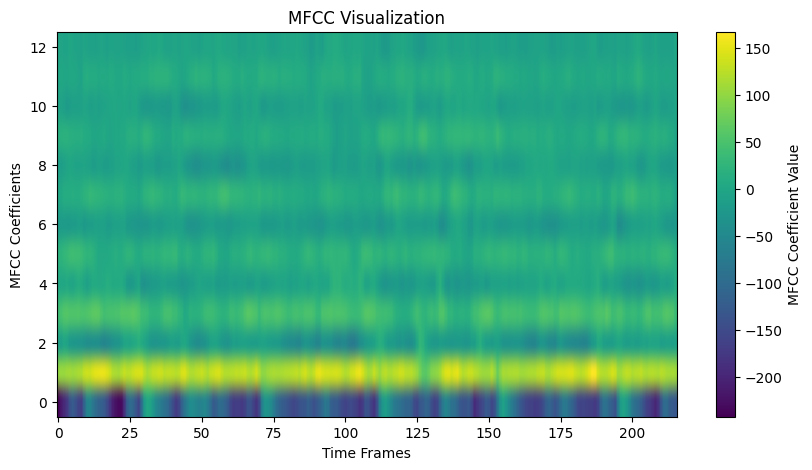

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load file MFCC .npy
mfcc = np.load("/content/drive/MyDrive/dataset/mfcc_npy/blues_blues.00000_original.wav_segment1.npy")

print("Shape dari MFCC:", mfcc.shape)

# Transpose agar sumbu sesuai (Time Frames di X, MFCC Coefficients di Y)
mfcc = mfcc.T

# Plot MFCC sebagai heatmap
plt.figure(figsize=(10, 5))
plt.imshow(mfcc, aspect='auto', origin='lower', cmap='viridis')

# Tambahkan label dan judul yang benar
plt.colorbar(label="MFCC Coefficient Value")
plt.xlabel("Time Frames")  # Waktu di sumbu X
plt.ylabel("MFCC Coefficients")  # MFCC di sumbu Y
plt.title("MFCC Visualization")

# Tampilkan plot
plt.show()

In [ ]:
import os

file_path = "/content/drive/MyDrive/dataset/mfcc_npy/blues_blues.00000_original.wav_segment1.npy"

# Cek ukuran file dalam byte
file_size = os.path.getsize(file_path)

# Konversi ke KB atau MB untuk lebih mudah dibaca
file_size_kb = file_size / 1024  # dalam KB
file_size_mb = file_size_kb / 1024  # dalam MB

print(f"Ukuran file: {file_size} bytes ({file_size_kb:.2f} KB / {file_size_mb:.2f} MB)")


Ukuran file: 11360 bytes (11.09 KB / 0.01 MB)


## Processing Data

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# === LOAD DATA ===
json_path = "/content/drive/MyDrive/dataset/segmented_audio.json"

# Muat file JSON
with open(json_path, "r") as f:
    data_segments = json.load(f)

# === PREPARE DATASET ===
X, y = [], []
genre_to_label = {}  # Untuk mapping genre ke angka

for segment in data_segments:
    npy_path = segment["npy_path"]
    genre = segment["genre"]

    # Mapping genre ke angka
    if genre not in genre_to_label:
        genre_to_label[genre] = len(genre_to_label)

    try:
        # Load MFCC dari .npy
        mfcc = np.load(npy_path)
        X.append(mfcc)
        y.append(genre_to_label[genre])
    except Exception as e:
        print(f"Error loading {npy_path}: {e}")

# Konversi ke array numpy
X = np.array(X)  # Shape: (num_samples, time_steps, n_mfcc)
y = np.array(y)  # Shape: (num_samples,)

# Pastikan input memiliki dimensi yang benar untuk CNN (tambah 1 channel)
X = X[..., np.newaxis]  # Shape: (num_samples, time_steps, n_mfcc, 1)

# One-hot encoding untuk label genre
num_classes = len(genre_to_label)
y_categorical = to_categorical(y, num_classes)

print("Dataset siap digunakan!")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-1b902a4a9266>", line 30, in <cell line: 0>
    mfcc = np.load(npy_path)
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/npyio.py", line 434, in load
    magic = fid.read(N)
            ^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPyt

TypeError: object of type 'NoneType' has no len()

# Testing 2 (Segmentation to drive in 1 npz file > faster data load)

## Audio 5s Segmentation with Data Augmentation


### Feature Extraction (Single File npy)

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

# Path ke folder dataset
general_path = '/content/drive/MyDrive/dataset/genres_augmented'
output_csv = '/content/drive/MyDrive/dataset/segmented_audio_5s.csv'
output_json = '/content/drive/MyDrive/dataset/segmented_audio_5s.json'
output_npy = '/content/drive/MyDrive/dataset/mfcc_dataset.npz'  # File npz untuk menyimpan semua data MFCC

# Parameter segmentasi dan ekstraksi fitur
segment_duration = 5  # Durasi segmentasi dalam detik
n_mfcc = 13  # Jumlah MFCC yang diekstrak
n_fft = 2048
hop_length = 512

# Menampung hasil segmentasi
X, y = [], []
data_segments = []
genre_to_label = {}

# Loop melalui setiap genre
genres = os.listdir(general_path)
for genre in genres:
    genre_dir = os.path.join(general_path, genre)
    if os.path.isdir(genre_dir):
        print(f"Memproses genre: {genre}")

        # Mapping genre ke angka
        if genre not in genre_to_label:
            genre_to_label[genre] = len(genre_to_label)

        # Loop melalui setiap file dalam genre
        for filename in tqdm(os.listdir(genre_dir)):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_dir, filename)

                try:
                    # Load audio file
                    data, sr = librosa.load(file_path, sr=None)

                    # Segmentasi audio
                    segment_length = int(segment_duration * sr)
                    num_segments = len(data) // segment_length

                    # Proses setiap segmen
                    for idx in range(num_segments):
                        start_sample = idx * segment_length
                        finish_sample = start_sample + segment_length
                        segment = data[start_sample:finish_sample]

                        if len(segment) == segment_length:
                            # Ekstraksi MFCC (format 2D)
                            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc,
                                                        n_fft=n_fft, hop_length=hop_length)
                            mfcc = mfcc.T  # Transpose agar (time_steps, n_mfcc)

                            # Simpan ke array
                            X.append(mfcc)
                            y.append(genre_to_label[genre])

                            # Simpan informasi segmen
                            segment_info = {
                                'genre': genre,
                                'filename': filename,
                                'segment_index': idx + 1,
                                'mfcc_shape': mfcc.shape,  # (time_steps, n_mfcc)
                                'genre_label': genre_to_label[genre]
                            }
                            data_segments.append(segment_info)

                except Exception as e:
                    print(f"Kesalahan saat memproses {file_path}: {e}")

# Konversi ke array numpy
X = np.array(X)[..., np.newaxis]  # Shape: (num_samples, time_steps, n_mfcc, 1)
y = np.array(y)  # Label dalam bentuk angka

# Simpan dataset dalam satu file .npz
np.savez(output_npy, X=X, y=y)
print(f"Dataset MFCC disimpan dalam satu file: {output_npy}")

# Simpan hasil ke CSV
csv_data = pd.DataFrame(data_segments)
csv_data.to_csv(output_csv, index=False)
print(f"Hasil segmentasi disimpan ke: {output_csv}")

# Simpan hasil ke JSON
with open(output_json, 'w') as json_file:
    json.dump(data_segments, json_file, indent=4)
print(f"Hasil segmentasi disimpan ke: {output_json}")

Memproses genre: hiphop


100%|██████████| 400/400 [01:36<00:00,  4.12it/s]


Memproses genre: country


100%|██████████| 400/400 [01:02<00:00,  6.35it/s]


Memproses genre: classical


100%|██████████| 400/400 [00:55<00:00,  7.16it/s]


Memproses genre: rock


100%|██████████| 400/400 [01:02<00:00,  6.42it/s]


Memproses genre: pop


100%|██████████| 400/400 [00:57<00:00,  6.93it/s]


Memproses genre: jazz


100%|██████████| 396/396 [01:03<00:00,  6.19it/s]


Memproses genre: reggae


100%|██████████| 400/400 [01:01<00:00,  6.54it/s]


Memproses genre: disco


100%|██████████| 400/400 [00:56<00:00,  7.11it/s]


Memproses genre: blues


100%|██████████| 400/400 [01:08<00:00,  5.88it/s]


Memproses genre: metal


100%|██████████| 400/400 [00:56<00:00,  7.12it/s]


Memproses genre: .ipynb_checkpoints


0it [00:00, ?it/s]


Dataset MFCC disimpan dalam satu file: /content/drive/MyDrive/dataset/mfcc_dataset.npz
Hasil segmentasi disimpan ke: /content/drive/MyDrive/dataset/segmented_audio_5s.csv
Hasil segmentasi disimpan ke: /content/drive/MyDrive/dataset/segmented_audio_5s.json


### Processing Data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# === LOAD DATA ===
npz_path = "/content/drive/MyDrive/dataset/mfcc_dataset.npz"

# Muat dataset dari file .npz
data = np.load(npz_path)
X = data["X"]  # Shape: (num_samples, time_steps, n_mfcc, 1)
y = data["y"]  # Shape: (num_samples,)

# One-hot encoding untuk label genre
num_classes = len(np.unique(y))  # Hitung jumlah kelas unik dalam y
y_categorical = to_categorical(y, num_classes)

print("Dataset berhasil dimuat!")
print(f"Shape X: {X.shape}, Shape y: {y_categorical.shape}")

Dataset berhasil dimuat!
Shape X: (23940, 216, 13, 1), Shape y: (23940, 10)


In [ ]:
import json
import numpy as np
from tensorflow.keras.utils import to_categorical

# Path ke file JSON yang menyimpan informasi segmentasi
json_path = "/content/drive/MyDrive/dataset/segmented_audio_5s.json"

# Muat informasi segmentasi
with open(json_path, "r") as json_file:
    data_segments = json.load(json_file)

# Buat kembali genre_to_label dari data segmentasi
genre_to_label = {segment["genre"]: segment["genre_label"] for segment in data_segments}

# Tampilkan isi genre_to_label
print("Mapping Genre ke Label:")
for genre, label in genre_to_label.items():
    print(f"{genre}: {label}")

# === LOAD DATA ===
npz_path = "/content/drive/MyDrive/dataset/mfcc_dataset.npz"

# Muat dataset dari file .npz
data = np.load(npz_path)
X = data["X"]  # Shape: (num_samples, time_steps, n_mfcc, 1)
y = data["y"]  # Shape: (num_samples,)

# One-hot encoding untuk label genre
num_classes = len(np.unique(y))  # Hitung jumlah kelas unik dalam y
y_categorical = to_categorical(y, num_classes)

print("\nDataset berhasil dimuat!")
print(f"Shape X: {X.shape}, Shape y: {y_categorical.shape}")

Mapping Genre ke Label:
hiphop: 0
country: 1
classical: 2
rock: 3
pop: 4
jazz: 5
reggae: 6
disco: 7
blues: 8
metal: 9

Dataset berhasil dimuat!
Shape X: (23940, 216, 13, 1), Shape y: (23940, 10)


# Testing 3 (Model Configuration for prevent overfit > Best Model Configuration)

### CRNN Model (30% Dropout)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_crnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu'))  # Dense pertama dengan 64 unit dan ReLU
    model.add(Dropout(0.3))  # Dropout 30% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense kedua untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation (Training & Evaluasi)

##### Gagal

In [ ]:
import shutil
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
model_paths = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluasi
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Accuracy: {val_acc:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    y_true_classes = np.argmax(y_val, axis=1)  # Konversi one-hot ke label asli

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Simpan model setiap fold
    model_path = f"/content/drive/MyDrive/dataset/crnn_model_fold{fold+1}.h5"
    model.save(model_path)
    model_paths.append(model_path)
    print(f"Model untuk Fold {fold+1} telah disimpan!")

# Pilih model terbaik berdasarkan akurasi tertinggi
best_fold = np.argmax(fold_accuracies) + 1  # Fold dengan akurasi tertinggi
best_model_path = f"/content/drive/MyDrive/dataset/crnn_model_fold{best_fold}.h5"

# Simpan sebagai model akhir
final_model_path = "/content/drive/MyDrive/dataset/crnn_model_best.h5"
shutil.copy(best_model_path, final_model_path)
print(f"\nModel terbaik dari Fold {best_fold} telah disimpan sebagai {final_model_path}")

print("Training selesai!")


===== Fold 1/10 =====
Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.2900 - loss: 1.9891 - val_accuracy: 0.4887 - val_loss: 1.4699
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4653 - loss: 1.5046 - val_accuracy: 0.5426 - val_loss: 1.3104
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.5194 - loss: 1.3507 - val_accuracy: 0.5723 - val_loss: 1.2160
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.5554 - loss: 1.2597 - val_accuracy: 0.5902 - val_loss: 1.1520
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.5864 - loss: 1.1758 - val_accuracy: 0.6186 - val_loss: 1.1018
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.6022 - loss: 1.1266 - val_accuracy: 0.6249 - val_loss: 1.0899
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.6205 - loss: 1.0849 - val_accuracy: 0.6282 - val_loss: 1.0531
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0

Fold 1 Precision: 0.8213
Fold 1 Recall: 0.8197
Fold 1 F1-Score: 0.8185
Model untuk Fold 1 telah disimpan!

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.2767 - loss: 2.0164 - val_accuracy: 0.4674 - val_loss: 1.4803
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.4569 - loss: 1.5032 - val_accuracy: 0.5242 - val_loss: 1.3134
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.5111 - loss: 1.3453 - val_accuracy: 0.5806 - val_loss: 1.1659
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.5630 - loss: 1.2458 - val_accuracy: 0.5973 - val_loss: 1.1343
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5861 - loss: 1.1745 - val_accuracy: 0.6153 - val_loss: 1.0670
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.6113 - loss: 1.1164 - val_accuracy: 0.6491 - val_loss: 1.0115
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.6305 - loss: 1.0648 - val_accuracy: 0.6416 - val_loss: 0.9959
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6539 - loss: 1.0185 - 

Fold 2 Precision: 0.8124
Fold 2 Recall: 0.8064
Fold 2 F1-Score: 0.8065
Model untuk Fold 2 telah disimpan!

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.2793 - loss: 2.0193 - val_accuracy: 0.4699 - val_loss: 1.4940
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.4614 - loss: 1.5005 - val_accuracy: 0.5242 - val_loss: 1.3401
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.5181 - loss: 1.3554 - val_accuracy: 0.5714 - val_loss: 1.2214
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.5612 - loss: 1.2519 - val_accuracy: 0.5898 - val_loss: 1.1746
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.5896 - loss: 1.1868 - val_accuracy: 0.5927 - val_loss: 1.1364
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6006 - loss: 1.1316 - val_accuracy: 0.6320 - val_loss: 1.0511
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.6229 - loss: 1.0685 - val_accuracy: 0.6378 - val_loss: 1.0257
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6293 - loss: 1.0439 - 

Fold 3 Precision: 0.8070
Fold 3 Recall: 0.8061
Fold 3 F1-Score: 0.8054
Model untuk Fold 3 telah disimpan!

===== Fold 4/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.2836 - loss: 2.0089 - val_accuracy: 0.4850 - val_loss: 1.4596
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4658 - loss: 1.5054 - val_accuracy: 0.5054 - val_loss: 1.3332
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.5103 - loss: 1.3578 - val_accuracy: 0.5309 - val_loss: 1.2658
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5483 - loss: 1.2737 - val_accuracy: 0.5794 - val_loss: 1.1516
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5713 - loss: 1.2053 - val_accuracy: 0.6115 - val_loss: 1.0817
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.5984 - loss: 1.1204 - val_accuracy: 0.6007 - val_loss: 1.0979
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.6260 - loss: 1.0757 - val_accuracy: 0.6404 - val_loss: 1.0060
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6325 - loss: 1.0426 - 

Fold 4 Precision: 0.8195
Fold 4 Recall: 0.8154
Fold 4 F1-Score: 0.8150
Model untuk Fold 4 telah disimpan!

===== Fold 5/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.2638 - loss: 2.0096 - val_accuracy: 0.4495 - val_loss: 1.5177
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.4617 - loss: 1.5101 - val_accuracy: 0.5259 - val_loss: 1.3104
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.5293 - loss: 1.3240 - val_accuracy: 0.5647 - val_loss: 1.2285
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.5622 - loss: 1.2333 - val_accuracy: 0.5827 - val_loss: 1.1558
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.5899 - loss: 1.1688 - val_accuracy: 0.6115 - val_loss: 1.0746
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.6041 - loss: 1.1118 - val_accuracy: 0.6303 - val_loss: 1.0347
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6266 - loss: 1.0701 - val_accuracy: 0.6353 - val_loss: 1.0079
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.6408 - loss: 1.0360 - 

KeyboardInterrupt: 

##### Tidak diketahui overfitting atau tidak

In [ ]:
import numpy as np
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

best_accuracy = 0.0
best_model_path = ""

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluasi
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Accuracy: {val_acc:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Simpan model jika akurasi lebih baik
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model_path = f"/content/drive/MyDrive/dataset/crnn_model_best.h5"
        model.save(best_model_path)
        print(f"Model terbaik saat ini disimpan dari Fold {fold+1} dengan akurasi {val_acc:.4f}")

print("Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.2758 - loss: 2.0075 - val_accuracy: 0.4557 - val_loss: 1.5098
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4573 - loss: 1.5193 - val_accuracy: 0.5046 - val_loss: 1.3569
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.4991 - loss: 1.3992 - val_accuracy: 0.5451 - val_loss: 1.2746
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.5347 - loss: 1.2929 - val_accuracy: 0.5706 - val_loss: 1.2059
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.5593 - loss: 1.2295 - val_accuracy: 0.5794 - val_loss: 1.1663
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.5795 - loss: 1.1712 - val_accuracy: 0.6032 - val_loss: 1.1102
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.6000 - loss: 1.1220 - val_accuracy: 0.6103 - val_loss: 1.0747
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6124 - loss: 1.0797 - 

Fold 1 Precision: 0.8092
Fold 1 Recall: 0.8094
Fold 1 F1-Score: 0.8064
Model terbaik saat ini disimpan dari Fold 1 dengan akurasi 0.8074

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.2585 - loss: 2.0105 - val_accuracy: 0.4662 - val_loss: 1.5009
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.4620 - loss: 1.4998 - val_accuracy: 0.5301 - val_loss: 1.3063
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.5177 - loss: 1.3425 - val_accuracy: 0.5781 - val_loss: 1.1944
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.5439 - loss: 1.2681 - val_accuracy: 0.6040 - val_loss: 1.1185
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5871 - loss: 1.1663 - val_accuracy: 0.6053 - val_loss: 1.1053
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5993 - loss: 1.1305 - val_accuracy: 0.6153 - val_loss: 1.0497
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6249 - loss: 1.0717 - val_accuracy: 0.6366 - val_loss: 1.0282
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6315 - loss: 1.0446 - 

Fold 2 Precision: 0.8222
Fold 2 Recall: 0.8142
Fold 2 F1-Score: 0.8148
Model terbaik saat ini disimpan dari Fold 2 dengan akurasi 0.8150

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.2730 - loss: 2.0391 - val_accuracy: 0.4683 - val_loss: 1.5325
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4647 - loss: 1.4960 - val_accuracy: 0.5409 - val_loss: 1.3179
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5106 - loss: 1.3818 - val_accuracy: 0.5614 - val_loss: 1.2436
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5483 - loss: 1.2794 - val_accuracy: 0.5823 - val_loss: 1.1808
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.5684 - loss: 1.2158 - val_accuracy: 0.5957 - val_loss: 1.1286
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.5854 - loss: 1.1653 - val_accuracy: 0.6174 - val_loss: 1.0861
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6071 - loss: 1.1140 - val_accuracy: 0.6345 - val_loss: 1.0541
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.6264 - loss: 1.0652 - 

Fold 3 Precision: 0.8200
Fold 3 Recall: 0.8176
Fold 3 F1-Score: 0.8180
Model terbaik saat ini disimpan dari Fold 3 dengan akurasi 0.8154

===== Fold 4/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.2686 - loss: 2.0207 - val_accuracy: 0.4574 - val_loss: 1.4897
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.4461 - loss: 1.5372 - val_accuracy: 0.4595 - val_loss: 1.4312
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.4895 - loss: 1.4113 - val_accuracy: 0.5343 - val_loss: 1.2682
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.5310 - loss: 1.3062 - val_accuracy: 0.5702 - val_loss: 1.1998
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.5527 - loss: 1.2406 - val_accuracy: 0.5977 - val_loss: 1.1329
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5809 - loss: 1.1700 - val_accuracy: 0.6099 - val_loss: 1.0853
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6034 - loss: 1.1184 - val_accuracy: 0.6211 - val_loss: 1.0682
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6297 - loss: 1.0541 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.2790 - loss: 2.0359 - val_accuracy: 0.4520 - val_loss: 1.5052
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.4676 - loss: 1.5014 - val_accuracy: 0.5159 - val_loss: 1.3409
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.5216 - loss: 1.3417 - val_accuracy: 0.5505 - val_loss: 1.2236
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.5607 - loss: 1.2402 - val_accuracy: 0.5831 - val_loss: 1.1634
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5853 - loss: 1.1747 - val_accuracy: 0.6053 - val_loss: 1.1101
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.6083 - loss: 1.1197 - val_accuracy: 0.5957 - val_loss: 1.1364
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6163 - loss: 1.0958 - val_accuracy: 0.6245 - val_loss: 1.0523
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6402 - loss: 1.0360 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.2985 - loss: 1.9764 - val_accuracy: 0.4557 - val_loss: 1.5181
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.4609 - loss: 1.5003 - val_accuracy: 0.5234 - val_loss: 1.3025
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.5173 - loss: 1.3426 - val_accuracy: 0.5773 - val_loss: 1.2020
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.5600 - loss: 1.2343 - val_accuracy: 0.5911 - val_loss: 1.1275
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5834 - loss: 1.1820 - val_accuracy: 0.6086 - val_loss: 1.0859
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6058 - loss: 1.1266 - val_accuracy: 0.6253 - val_loss: 1.0535
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6292 - loss: 1.0638 - val_accuracy: 0.6491 - val_loss: 0.9888
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.6392 - loss: 1.0266 - 

Fold 6 Precision: 0.8232
Fold 6 Recall: 0.8228
Fold 6 F1-Score: 0.8226
Model terbaik saat ini disimpan dari Fold 6 dengan akurasi 0.8233

===== Fold 7/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.2637 - loss: 2.0342 - val_accuracy: 0.4942 - val_loss: 1.4215
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.4586 - loss: 1.4926 - val_accuracy: 0.5451 - val_loss: 1.2635
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.5231 - loss: 1.3311 - val_accuracy: 0.5789 - val_loss: 1.1905
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.5505 - loss: 1.2585 - val_accuracy: 0.6048 - val_loss: 1.1094
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5759 - loss: 1.1927 - val_accuracy: 0.6103 - val_loss: 1.0799
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5968 - loss: 1.1420 - val_accuracy: 0.6391 - val_loss: 1.0317
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.6119 - loss: 1.1006 - val_accuracy: 0.6362 - val_loss: 0.9969
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.6214 - loss: 1.0681 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.2973 - loss: 1.9532 - val_accuracy: 0.4678 - val_loss: 1.4820
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.4656 - loss: 1.4994 - val_accuracy: 0.5134 - val_loss: 1.3541
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.5058 - loss: 1.3884 - val_accuracy: 0.5480 - val_loss: 1.2723
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5441 - loss: 1.3003 - val_accuracy: 0.5698 - val_loss: 1.1954
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5585 - loss: 1.2516 - val_accuracy: 0.5585 - val_loss: 1.2250
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5766 - loss: 1.2001 - val_accuracy: 0.5948 - val_loss: 1.1329
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5949 - loss: 1.1413 - val_accuracy: 0.5756 - val_loss: 1.1896
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.6074 - loss: 1.1058 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.2757 - loss: 2.0070 - val_accuracy: 0.4816 - val_loss: 1.4669
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4532 - loss: 1.5296 - val_accuracy: 0.5238 - val_loss: 1.3417
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.4874 - loss: 1.4226 - val_accuracy: 0.5476 - val_loss: 1.2756
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5221 - loss: 1.3329 - val_accuracy: 0.5685 - val_loss: 1.1961
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5492 - loss: 1.2659 - val_accuracy: 0.5911 - val_loss: 1.1507
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5663 - loss: 1.2210 - val_accuracy: 0.6149 - val_loss: 1.0858
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.5866 - loss: 1.1596 - val_accuracy: 0.6287 - val_loss: 1.0559
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6005 - loss: 1.1276 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.2971 - loss: 1.9651 - val_accuracy: 0.4896 - val_loss: 1.4455
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.4710 - loss: 1.4580 - val_accuracy: 0.5305 - val_loss: 1.2744
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.5293 - loss: 1.3105 - val_accuracy: 0.5656 - val_loss: 1.2092
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.5578 - loss: 1.2354 - val_accuracy: 0.6086 - val_loss: 1.1117
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5939 - loss: 1.1600 - val_accuracy: 0.6099 - val_loss: 1.1024
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6135 - loss: 1.1008 - val_accuracy: 0.6332 - val_loss: 1.0284
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.6284 - loss: 1.0601 - val_accuracy: 0.6216 - val_loss: 1.0552
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.6525 - loss: 1.0056 - 

##### Kode dasar testing k-fold

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_5seg_augmented.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.2602 - loss: 2.0272 - val_accuracy: 0.4741 - val_loss: 1.4678
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4581 - loss: 1.5123 - val_accuracy: 0.5163 - val_loss: 1.3410
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.5102 - loss: 1.3729 - val_accuracy: 0.5405 - val_loss: 1.2778
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.5460 - loss: 1.2717 - val_accuracy: 0.5606 - val_loss: 1.2443
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.5730 - loss: 1.2121 - val_accuracy: 0.5936 - val_loss: 1.1500
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5934 - loss: 1.1521 - val_accuracy: 0.6061 - val_loss: 1.1287
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.6095 - loss: 1.1129 - val_accuracy: 0.6232 - val_loss: 1.0618
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6228 - loss: 1.0551 - 

Fold 1 Precision: 0.8227
Fold 1 Recall: 0.8136
Fold 1 F1-Score: 0.8145
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8907, Val Acc: 0.8112)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.8112 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.2789 - loss: 2.0057 - val_accuracy: 0.4774 - val_loss: 1.4667
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.4597 - loss: 1.5048 - val_accuracy: 0.5380 - val_loss: 1.3021
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5144 - loss: 1.3609 - val_accuracy: 0.5723 - val_loss: 1.2072
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5430 - loss: 1.2921 - val_accuracy: 0.5635 - val_loss: 1.2240
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5669 - loss: 1.2343 - val_accuracy: 0.6003 - val_loss: 1.1228
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5879 - loss: 1.1619 - val_accuracy: 0.6257 - val_loss: 1.0509
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.6114 - loss: 1.0972 - val_accuracy: 0.6299 - val_loss: 1.0282
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.6289 - loss: 1.0644 - 

Fold 2 Precision: 0.8293
Fold 2 Recall: 0.8266
Fold 2 F1-Score: 0.8270
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8768, Val Acc: 0.8266)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8266 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.2868 - loss: 1.9956 - val_accuracy: 0.4837 - val_loss: 1.4459
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.4780 - loss: 1.4596 - val_accuracy: 0.5439 - val_loss: 1.3167
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5230 - loss: 1.3372 - val_accuracy: 0.5677 - val_loss: 1.2275
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.5516 - loss: 1.2645 - val_accuracy: 0.5873 - val_loss: 1.1778
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.5767 - loss: 1.2074 - val_accuracy: 0.6107 - val_loss: 1.1269
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5991 - loss: 1.1413 - val_accuracy: 0.6094 - val_loss: 1.1015
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.6084 - loss: 1.1105 - val_accuracy: 0.6153 - val_loss: 1.0576
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6386 - loss: 1.0595 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.2712 - loss: 2.0225 - val_accuracy: 0.4428 - val_loss: 1.5342
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.4499 - loss: 1.5383 - val_accuracy: 0.4975 - val_loss: 1.3785
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.5013 - loss: 1.3920 - val_accuracy: 0.5430 - val_loss: 1.2762
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5449 - loss: 1.2940 - val_accuracy: 0.5497 - val_loss: 1.2501
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5644 - loss: 1.2447 - val_accuracy: 0.5827 - val_loss: 1.1557
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.5847 - loss: 1.1871 - val_accuracy: 0.5961 - val_loss: 1.1211
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.6040 - loss: 1.1352 - val_accuracy: 0.6061 - val_loss: 1.0769
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6169 - loss: 1.0887 - 

Fold 4 Precision: 0.8323
Fold 4 Recall: 0.8292
Fold 4 F1-Score: 0.8296
✅ Fold 4 memiliki generalisasi yang **baik** (Train Acc: 0.8796, Val Acc: 0.8296)
✅ Model terbaik disimpan dari Fold 4 dengan akurasi 0.8296 dan generalisasi yang baik

===== Fold 5/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.2829 - loss: 1.9960 - val_accuracy: 0.4599 - val_loss: 1.4775
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.4630 - loss: 1.4806 - val_accuracy: 0.5138 - val_loss: 1.3302
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5065 - loss: 1.3637 - val_accuracy: 0.5251 - val_loss: 1.2839
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5468 - loss: 1.2803 - val_accuracy: 0.5426 - val_loss: 1.2223
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.5666 - loss: 1.2294 - val_accuracy: 0.5593 - val_loss: 1.1957
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.5906 - loss: 1.1540 - val_accuracy: 0.5789 - val_loss: 1.1665
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6052 - loss: 1.1126 - val_accuracy: 0.6028 - val_loss: 1.0965
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.6252 - loss: 1.0682 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.2616 - loss: 1.9972 - val_accuracy: 0.4678 - val_loss: 1.4615
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.4625 - loss: 1.4820 - val_accuracy: 0.5180 - val_loss: 1.3364
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5120 - loss: 1.3498 - val_accuracy: 0.5610 - val_loss: 1.2115
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5494 - loss: 1.2675 - val_accuracy: 0.5748 - val_loss: 1.1632
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5739 - loss: 1.1898 - val_accuracy: 0.6048 - val_loss: 1.0912
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5857 - loss: 1.1517 - val_accuracy: 0.6165 - val_loss: 1.0502
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6109 - loss: 1.0895 - val_accuracy: 0.6128 - val_loss: 1.0438
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6266 - loss: 1.0540 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2825 - loss: 1.9697 - val_accuracy: 0.4871 - val_loss: 1.4296
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4656 - loss: 1.4768 - val_accuracy: 0.5359 - val_loss: 1.2992
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5232 - loss: 1.3400 - val_accuracy: 0.5714 - val_loss: 1.2016
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5421 - loss: 1.2754 - val_accuracy: 0.6019 - val_loss: 1.1138
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5672 - loss: 1.1966 - val_accuracy: 0.6136 - val_loss: 1.0804
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5867 - loss: 1.1558 - val_accuracy: 0.6220 - val_loss: 1.0659
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6073 - loss: 1.1055 - val_accuracy: 0.6312 - val_loss: 1.0199
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6321 - loss: 1.0509 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2871 - loss: 1.9881 - val_accuracy: 0.4520 - val_loss: 1.4925
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4685 - loss: 1.4679 - val_accuracy: 0.5334 - val_loss: 1.2953
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.5285 - loss: 1.3267 - val_accuracy: 0.5802 - val_loss: 1.1731
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5655 - loss: 1.2324 - val_accuracy: 0.5890 - val_loss: 1.1498
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.5879 - loss: 1.1730 - val_accuracy: 0.6069 - val_loss: 1.0865
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6069 - loss: 1.1112 - val_accuracy: 0.6366 - val_loss: 1.0353
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.6225 - loss: 1.0725 - val_accuracy: 0.6437 - val_loss: 0.9834
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.6405 - loss: 1.0242 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.2819 - loss: 2.0062 - val_accuracy: 0.4670 - val_loss: 1.4627
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.4429 - loss: 1.5363 - val_accuracy: 0.5363 - val_loss: 1.3054
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4885 - loss: 1.4154 - val_accuracy: 0.5510 - val_loss: 1.2616
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.5266 - loss: 1.3151 - val_accuracy: 0.5860 - val_loss: 1.1635
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5555 - loss: 1.2425 - val_accuracy: 0.5936 - val_loss: 1.1503
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5786 - loss: 1.1841 - val_accuracy: 0.6207 - val_loss: 1.0747
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5880 - loss: 1.1626 - val_accuracy: 0.6249 - val_loss: 1.0564
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.6107 - loss: 1.1128 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2803 - loss: 1.9987 - val_accuracy: 0.4812 - val_loss: 1.4604
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.4607 - loss: 1.5009 - val_accuracy: 0.5180 - val_loss: 1.3231
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5089 - loss: 1.3756 - val_accuracy: 0.5610 - val_loss: 1.2246
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5574 - loss: 1.2526 - val_accuracy: 0.5931 - val_loss: 1.1311
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.5694 - loss: 1.2036 - val_accuracy: 0.6028 - val_loss: 1.1106
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5986 - loss: 1.1274 - val_accuracy: 0.6186 - val_loss: 1.0465
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6100 - loss: 1.0948 - val_accuracy: 0.6266 - val_loss: 1.0137
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6309 - loss: 1.0423 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8081 ± 0.0190
Precision: 0.8152 ± 0.0146
Recall: 0.8079 ± 0.0205
F1-Score: 0.8080 ± 0.0209


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8779
Rata-rata Akurasi Validasi Terakhir: 0.8081
Gap Akurasi: 0.0698
✅ Model memiliki generalisasi yang **baik**.


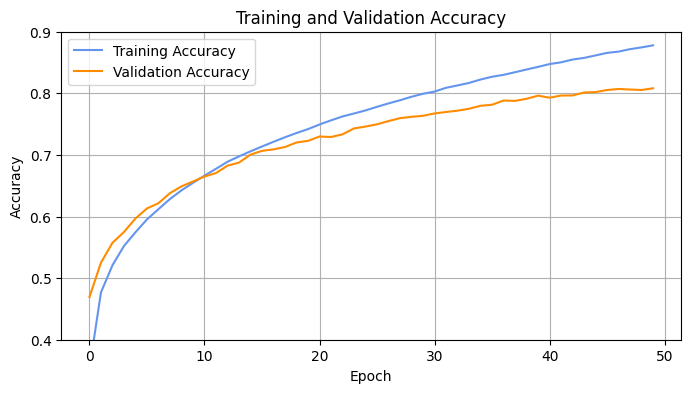

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

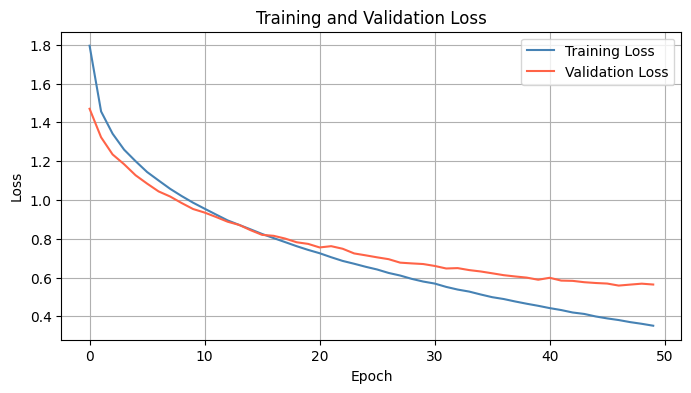

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

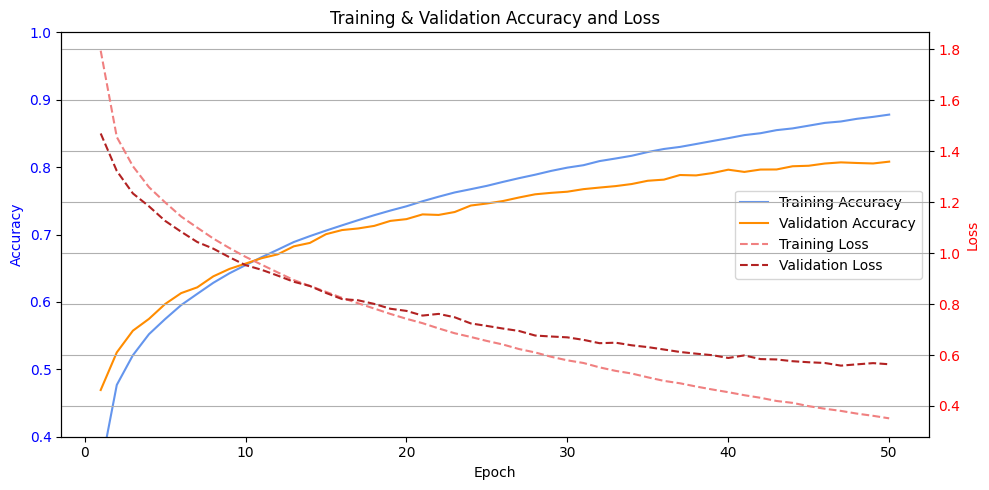

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (30% Dropout, Batch Normalization)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_crnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))  # Dropout 30% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_5seg_augmented.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.2562 - loss: 2.0860 - val_accuracy: 0.4791 - val_loss: 1.4869
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4597 - loss: 1.5302 - val_accuracy: 0.5134 - val_loss: 1.3435
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5161 - loss: 1.3840 - val_accuracy: 0.5647 - val_loss: 1.2152
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.5603 - loss: 1.2768 - val_accuracy: 0.6090 - val_loss: 1.1112
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.5955 - loss: 1.1953 - val_accuracy: 0.6295 - val_loss: 1.0654
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.6123 - loss: 1.1321 - val_accuracy: 0.6391 - val_loss: 1.0187
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.6354 - loss: 1.0819 - val_accuracy: 0.6466 - val_loss: 1.0192
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.6508 - loss: 1.0219 - 

Fold 1 Precision: 0.8335
Fold 1 Recall: 0.8290
Fold 1 F1-Score: 0.8301
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8874, Val Acc: 0.8292)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.8292 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.2510 - loss: 2.0860 - val_accuracy: 0.4269 - val_loss: 1.5232
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.4416 - loss: 1.5518 - val_accuracy: 0.5104 - val_loss: 1.3744
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5199 - loss: 1.3915 - val_accuracy: 0.5689 - val_loss: 1.2096
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5472 - loss: 1.2988 - val_accuracy: 0.6057 - val_loss: 1.1284
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5739 - loss: 1.2285 - val_accuracy: 0.6220 - val_loss: 1.0629
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5916 - loss: 1.1662 - val_accuracy: 0.6470 - val_loss: 0.9921
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6244 - loss: 1.0950 - val_accuracy: 0.6424 - val_loss: 1.0113
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6429 - loss: 1.0450 - 

Fold 2 Precision: 0.8418
Fold 2 Recall: 0.8427
Fold 2 F1-Score: 0.8411
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8862, Val Acc: 0.8413)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8413 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - accuracy: 0.2536 - loss: 2.0899 - val_accuracy: 0.4574 - val_loss: 1.5268
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - accuracy: 0.4470 - loss: 1.5659 - val_accuracy: 0.5150 - val_loss: 1.3329
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.4967 - loss: 1.4041 - val_accuracy: 0.5631 - val_loss: 1.2055
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5494 - loss: 1.2868 - val_accuracy: 0.6036 - val_loss: 1.1157
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5870 - loss: 1.2043 - val_accuracy: 0.6199 - val_loss: 1.0648
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6111 - loss: 1.1407 - val_accuracy: 0.6399 - val_loss: 1.0232
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6262 - loss: 1.0941 - val_accuracy: 0.6617 - val_loss: 0.9649
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6497 - loss: 1.0513 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.2558 - loss: 2.0565 - val_accuracy: 0.4779 - val_loss: 1.4503
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.4564 - loss: 1.5201 - val_accuracy: 0.5255 - val_loss: 1.3002
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5113 - loss: 1.3802 - val_accuracy: 0.5873 - val_loss: 1.1799
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.5578 - loss: 1.2806 - val_accuracy: 0.6044 - val_loss: 1.0989
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.5920 - loss: 1.1884 - val_accuracy: 0.6274 - val_loss: 1.0470
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.6177 - loss: 1.1240 - val_accuracy: 0.6571 - val_loss: 0.9875
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.6325 - loss: 1.0798 - val_accuracy: 0.6704 - val_loss: 0.9539
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.6534 - loss: 1.0346 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.2361 - loss: 2.1298 - val_accuracy: 0.4616 - val_loss: 1.4953
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4520 - loss: 1.5487 - val_accuracy: 0.5196 - val_loss: 1.3079
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5055 - loss: 1.3998 - val_accuracy: 0.5643 - val_loss: 1.2072
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.5468 - loss: 1.2880 - val_accuracy: 0.5856 - val_loss: 1.1489
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.5847 - loss: 1.2090 - val_accuracy: 0.6224 - val_loss: 1.0758
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5969 - loss: 1.1588 - val_accuracy: 0.6291 - val_loss: 1.0421
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6205 - loss: 1.1020 - val_accuracy: 0.6550 - val_loss: 1.0025
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6376 - loss: 1.0644 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.2714 - loss: 2.0764 - val_accuracy: 0.4574 - val_loss: 1.4957
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.4413 - loss: 1.5622 - val_accuracy: 0.5326 - val_loss: 1.3073
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5079 - loss: 1.3932 - val_accuracy: 0.5894 - val_loss: 1.1872
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.5565 - loss: 1.2690 - val_accuracy: 0.6216 - val_loss: 1.0968
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.5860 - loss: 1.1957 - val_accuracy: 0.6387 - val_loss: 1.0560
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.6075 - loss: 1.1454 - val_accuracy: 0.6454 - val_loss: 1.0191
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6278 - loss: 1.0824 - val_accuracy: 0.6600 - val_loss: 0.9669
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.6459 - loss: 1.0429 - 

Fold 6 Precision: 0.8490
Fold 6 Recall: 0.8473
Fold 6 F1-Score: 0.8475
✅ Fold 6 memiliki generalisasi yang **baik** (Train Acc: 0.8836, Val Acc: 0.8484)
✅ Model terbaik disimpan dari Fold 6 dengan akurasi 0.8484 dan generalisasi yang baik

===== Fold 7/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.2517 - loss: 2.0810 - val_accuracy: 0.4653 - val_loss: 1.5342
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.4332 - loss: 1.6088 - val_accuracy: 0.5226 - val_loss: 1.3529
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.4831 - loss: 1.4525 - val_accuracy: 0.5668 - val_loss: 1.2177
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.5287 - loss: 1.3441 - val_accuracy: 0.5944 - val_loss: 1.1620
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.5524 - loss: 1.2722 - val_accuracy: 0.6249 - val_loss: 1.0536
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.5871 - loss: 1.1930 - val_accuracy: 0.6324 - val_loss: 1.0353
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.6058 - loss: 1.1456 - val_accuracy: 0.6529 - val_loss: 0.9799
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6226 - loss: 1.1017 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.2665 - loss: 2.0685 - val_accuracy: 0.4378 - val_loss: 1.5306
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.4367 - loss: 1.5733 - val_accuracy: 0.4749 - val_loss: 1.3953
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.5118 - loss: 1.3854 - val_accuracy: 0.5489 - val_loss: 1.2474
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.5553 - loss: 1.2864 - val_accuracy: 0.6124 - val_loss: 1.1245
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5851 - loss: 1.2004 - val_accuracy: 0.6161 - val_loss: 1.0610
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - accuracy: 0.6122 - loss: 1.1345 - val_accuracy: 0.6512 - val_loss: 1.0215
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.6262 - loss: 1.0887 - val_accuracy: 0.6541 - val_loss: 0.9946
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6430 - loss: 1.0503 - 

Fold 8 Precision: 0.8540
Fold 8 Recall: 0.8518
Fold 8 F1-Score: 0.8516
✅ Fold 8 memiliki generalisasi yang **baik** (Train Acc: 0.8791, Val Acc: 0.8509)
✅ Model terbaik disimpan dari Fold 8 dengan akurasi 0.8509 dan generalisasi yang baik

===== Fold 9/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.2565 - loss: 2.0618 - val_accuracy: 0.5029 - val_loss: 1.4477
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4326 - loss: 1.5474 - val_accuracy: 0.5677 - val_loss: 1.2356
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5004 - loss: 1.3832 - val_accuracy: 0.5982 - val_loss: 1.1442
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5348 - loss: 1.2953 - val_accuracy: 0.6211 - val_loss: 1.0872
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5703 - loss: 1.2221 - val_accuracy: 0.6454 - val_loss: 1.0235
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5922 - loss: 1.1588 - val_accuracy: 0.6520 - val_loss: 1.0092
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.6293 - loss: 1.0876 - val_accuracy: 0.6667 - val_loss: 0.9530
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.6382 - loss: 1.0402 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.2598 - loss: 2.0723 - val_accuracy: 0.4641 - val_loss: 1.4910
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.4360 - loss: 1.5673 - val_accuracy: 0.5155 - val_loss: 1.3378
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5102 - loss: 1.4002 - val_accuracy: 0.5551 - val_loss: 1.2477
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.5582 - loss: 1.2790 - val_accuracy: 0.6149 - val_loss: 1.1113
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5786 - loss: 1.2209 - val_accuracy: 0.6274 - val_loss: 1.0646
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.6000 - loss: 1.1650 - val_accuracy: 0.6387 - val_loss: 1.0323
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.6279 - loss: 1.0997 - val_accuracy: 0.6583 - val_loss: 0.9783
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6441 - loss: 1.0585 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8317 ± 0.0163
Precision: 0.8344 ± 0.0145
Recall: 0.8316 ± 0.0154
F1-Score: 0.8307 ± 0.0172


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8791
Rata-rata Akurasi Validasi Terakhir: 0.8317
Gap Akurasi: 0.0474
✅ Model memiliki generalisasi yang **baik**.


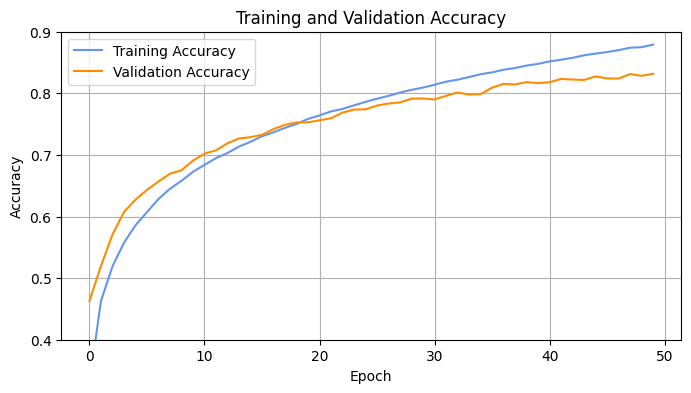

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

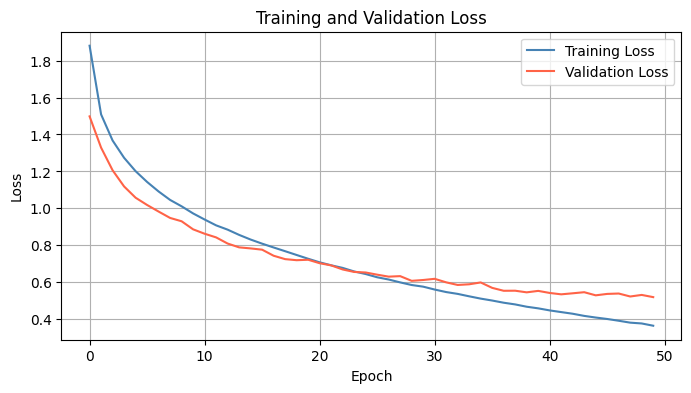

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

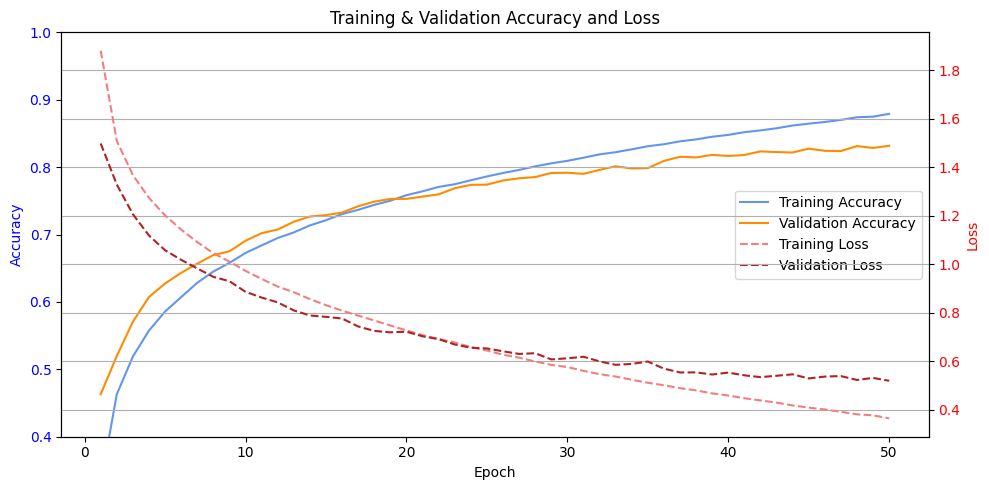

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (25% Dropout)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_crnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu'))  # Dense pertama dengan 64 unit dan ReLU
    model.add(Dropout(0.25))  # Dropout 25% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense kedua untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_25drop_5seg_augmented.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====
Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.2705 - loss: 2.0237 - val_accuracy: 0.4666 - val_loss: 1.4681
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4637 - loss: 1.4905 - val_accuracy: 0.5288 - val_loss: 1.3233
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5122 - loss: 1.3552 - val_accuracy: 0.5581 - val_loss: 1.2410
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5468 - loss: 1.2703 - val_accuracy: 0.5802 - val_loss: 1.1949
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5733 - loss: 1.2025 - val_accuracy: 0.5844 - val_loss: 1.1802
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5977 - loss: 1.1430 - val_accuracy: 0.6174 - val_loss: 1.0679
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6159 - loss: 1.0940 - val_accuracy: 0.6228 - val_loss: 1.0522
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0

Fold 1 Precision: 0.7972
Fold 1 Recall: 0.7885
Fold 1 F1-Score: 0.7910
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8837, Val Acc: 0.7882)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.7882 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.2837 - loss: 1.9973 - val_accuracy: 0.4841 - val_loss: 1.4505
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.4724 - loss: 1.4809 - val_accuracy: 0.5280 - val_loss: 1.2989
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5164 - loss: 1.3630 - val_accuracy: 0.5376 - val_loss: 1.2415
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5433 - loss: 1.2687 - val_accuracy: 0.5802 - val_loss: 1.1901
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5783 - loss: 1.1988 - val_accuracy: 0.5957 - val_loss: 1.1294
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5982 - loss: 1.1365 - val_accuracy: 0.6366 - val_loss: 1.0358
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6210 - loss: 1.0824 - val_accuracy: 0.6274 - val_loss: 1.0330
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.6324 - loss: 1.0492 - 

Fold 2 Precision: 0.8154
Fold 2 Recall: 0.8142
Fold 2 F1-Score: 0.8110
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8839, Val Acc: 0.8124)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8124 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2905 - loss: 1.9969 - val_accuracy: 0.4829 - val_loss: 1.4365
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.4781 - loss: 1.4512 - val_accuracy: 0.5317 - val_loss: 1.2814
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5371 - loss: 1.2891 - val_accuracy: 0.5735 - val_loss: 1.1994
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5638 - loss: 1.2289 - val_accuracy: 0.5923 - val_loss: 1.1574
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5894 - loss: 1.1487 - val_accuracy: 0.6149 - val_loss: 1.0928
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6088 - loss: 1.0872 - val_accuracy: 0.6253 - val_loss: 1.0769
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.6333 - loss: 1.0470 - val_accuracy: 0.6299 - val_loss: 1.0252
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.6495 - loss: 0.9993 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.2964 - loss: 1.9721 - val_accuracy: 0.4820 - val_loss: 1.4325
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.4782 - loss: 1.4423 - val_accuracy: 0.5317 - val_loss: 1.2821
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5386 - loss: 1.3051 - val_accuracy: 0.5723 - val_loss: 1.1766
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5667 - loss: 1.2138 - val_accuracy: 0.6032 - val_loss: 1.1090
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6012 - loss: 1.1337 - val_accuracy: 0.5986 - val_loss: 1.0950
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6310 - loss: 1.0674 - val_accuracy: 0.6328 - val_loss: 1.0280
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.6358 - loss: 1.0372 - val_accuracy: 0.6466 - val_loss: 0.9790
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6511 - loss: 0.9969 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.2790 - loss: 2.0142 - val_accuracy: 0.4499 - val_loss: 1.5095
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.4626 - loss: 1.4991 - val_accuracy: 0.4883 - val_loss: 1.3871
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5142 - loss: 1.3639 - val_accuracy: 0.5292 - val_loss: 1.2621
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5486 - loss: 1.2651 - val_accuracy: 0.5693 - val_loss: 1.1962
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5819 - loss: 1.1807 - val_accuracy: 0.5819 - val_loss: 1.1360
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5968 - loss: 1.1375 - val_accuracy: 0.6074 - val_loss: 1.0838
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6193 - loss: 1.0720 - val_accuracy: 0.6157 - val_loss: 1.0549
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6409 - loss: 1.0205 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.2728 - loss: 2.0081 - val_accuracy: 0.4599 - val_loss: 1.5524
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.4714 - loss: 1.4687 - val_accuracy: 0.5388 - val_loss: 1.3083
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5300 - loss: 1.3125 - val_accuracy: 0.5581 - val_loss: 1.2055
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5522 - loss: 1.2514 - val_accuracy: 0.5906 - val_loss: 1.1324
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5737 - loss: 1.1819 - val_accuracy: 0.6099 - val_loss: 1.0570
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.6054 - loss: 1.1111 - val_accuracy: 0.6195 - val_loss: 1.0280
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6241 - loss: 1.0595 - val_accuracy: 0.6370 - val_loss: 0.9967
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6318 - loss: 1.0434 - 

Fold 6 Precision: 0.8197
Fold 6 Recall: 0.8139
Fold 6 F1-Score: 0.8131
✅ Fold 6 memiliki generalisasi yang **baik** (Train Acc: 0.8837, Val Acc: 0.8145)
✅ Model terbaik disimpan dari Fold 6 dengan akurasi 0.8145 dan generalisasi yang baik

===== Fold 7/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.2838 - loss: 1.9953 - val_accuracy: 0.4825 - val_loss: 1.4705
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.4604 - loss: 1.5085 - val_accuracy: 0.5363 - val_loss: 1.3017
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.5102 - loss: 1.3663 - val_accuracy: 0.5798 - val_loss: 1.1848
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.5475 - loss: 1.2585 - val_accuracy: 0.5936 - val_loss: 1.1269
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5822 - loss: 1.1819 - val_accuracy: 0.6236 - val_loss: 1.0620
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6078 - loss: 1.1094 - val_accuracy: 0.6145 - val_loss: 1.0584
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6247 - loss: 1.0729 - val_accuracy: 0.6546 - val_loss: 0.9846
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6399 - loss: 1.0281 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.2941 - loss: 1.9911 - val_accuracy: 0.4591 - val_loss: 1.4915
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.4767 - loss: 1.4615 - val_accuracy: 0.5267 - val_loss: 1.2979
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5357 - loss: 1.3156 - val_accuracy: 0.5522 - val_loss: 1.2370
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5677 - loss: 1.2297 - val_accuracy: 0.5940 - val_loss: 1.1364
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5929 - loss: 1.1524 - val_accuracy: 0.5923 - val_loss: 1.1562
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.6123 - loss: 1.1113 - val_accuracy: 0.6245 - val_loss: 1.0595
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6292 - loss: 1.0582 - val_accuracy: 0.6516 - val_loss: 0.9944
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6430 - loss: 1.0154 - 

Fold 8 Precision: 0.8199
Fold 8 Recall: 0.8185
Fold 8 F1-Score: 0.8185
✅ Fold 8 memiliki generalisasi yang **baik** (Train Acc: 0.8881, Val Acc: 0.8170)
✅ Model terbaik disimpan dari Fold 8 dengan akurasi 0.8170 dan generalisasi yang baik

===== Fold 9/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.2735 - loss: 1.9982 - val_accuracy: 0.4925 - val_loss: 1.4291
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.4754 - loss: 1.4606 - val_accuracy: 0.5547 - val_loss: 1.2542
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5296 - loss: 1.3162 - val_accuracy: 0.5965 - val_loss: 1.1575
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.5557 - loss: 1.2395 - val_accuracy: 0.6048 - val_loss: 1.1137
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5880 - loss: 1.1606 - val_accuracy: 0.6353 - val_loss: 1.0586
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5896 - loss: 1.1425 - val_accuracy: 0.6445 - val_loss: 1.0013
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.6216 - loss: 1.0728 - val_accuracy: 0.6475 - val_loss: 1.0207
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6254 - loss: 1.0477 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.2965 - loss: 1.9679 - val_accuracy: 0.4716 - val_loss: 1.4766
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.4701 - loss: 1.4703 - val_accuracy: 0.5497 - val_loss: 1.2788
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5208 - loss: 1.3430 - val_accuracy: 0.5292 - val_loss: 1.2726
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5566 - loss: 1.2363 - val_accuracy: 0.5957 - val_loss: 1.1312
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.5815 - loss: 1.1856 - val_accuracy: 0.5998 - val_loss: 1.1000
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.5955 - loss: 1.1352 - val_accuracy: 0.6245 - val_loss: 1.0346
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6130 - loss: 1.0846 - val_accuracy: 0.6391 - val_loss: 1.0108
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6362 - loss: 1.0421 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8036 ± 0.0096
Precision: 0.8074 ± 0.0101
Recall: 0.8039 ± 0.0100
F1-Score: 0.8030 ± 0.0102


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8860
Rata-rata Akurasi Validasi Terakhir: 0.8036
Gap Akurasi: 0.0825
✅ Model memiliki generalisasi yang **baik**.


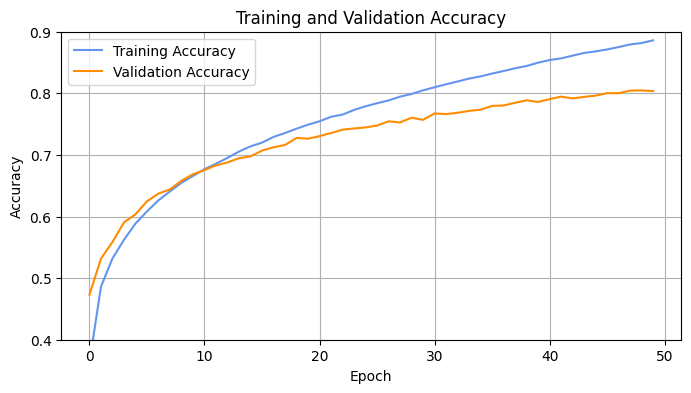

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

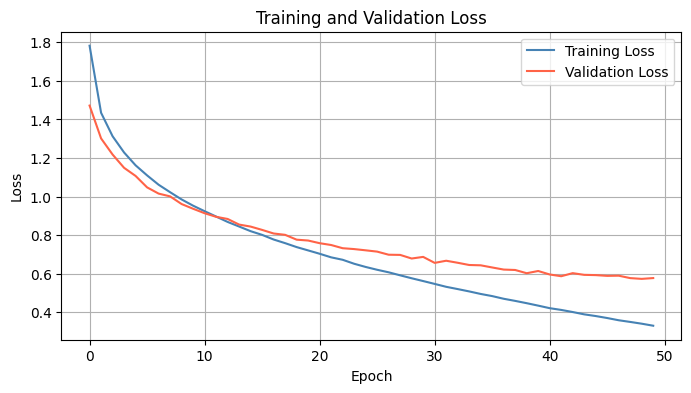

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

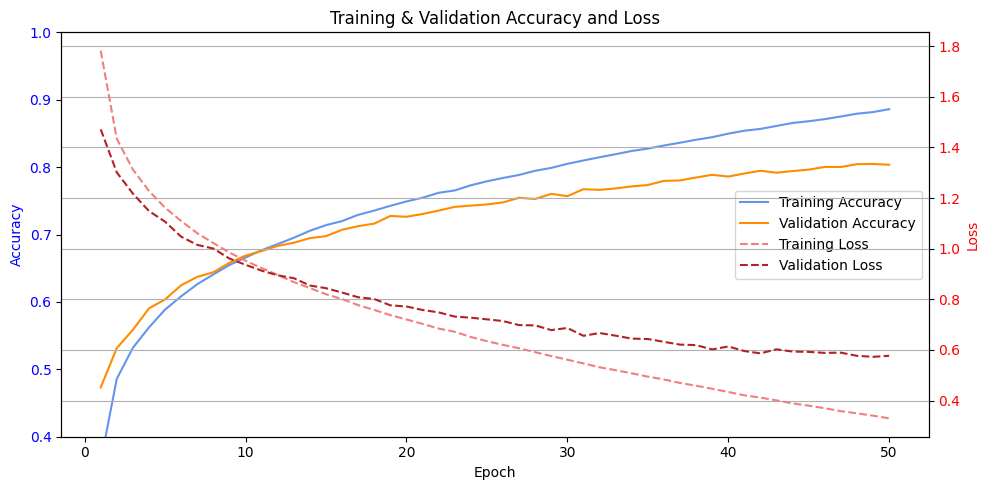

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (25% Dropout Dense Layer, Batch Normalization)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_crnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))  # Dropout 30% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_25drop_5seg_augmented.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.2704 - loss: 2.0681 - val_accuracy: 0.4557 - val_loss: 1.4966
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.4547 - loss: 1.5191 - val_accuracy: 0.5363 - val_loss: 1.3013
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5137 - loss: 1.3697 - val_accuracy: 0.5706 - val_loss: 1.1969
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.5460 - loss: 1.2787 - val_accuracy: 0.5982 - val_loss: 1.1244
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5723 - loss: 1.2053 - val_accuracy: 0.6028 - val_loss: 1.1394
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.6044 - loss: 1.1341 - val_accuracy: 0.6412 - val_loss: 1.0279
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6140 - loss: 1.1017 - val_accuracy: 0.6504 - val_loss: 0.9989
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.6396 - loss: 1.0391 - 

Fold 1 Precision: 0.8267
Fold 1 Recall: 0.8265
Fold 1 F1-Score: 0.8247
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8786, Val Acc: 0.8250)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.8250 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.2452 - loss: 2.0945 - val_accuracy: 0.4457 - val_loss: 1.5172
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.4476 - loss: 1.5371 - val_accuracy: 0.5155 - val_loss: 1.3477
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4892 - loss: 1.4156 - val_accuracy: 0.5489 - val_loss: 1.2702
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.5257 - loss: 1.3269 - val_accuracy: 0.5760 - val_loss: 1.1945
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5658 - loss: 1.2252 - val_accuracy: 0.6065 - val_loss: 1.1037
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5838 - loss: 1.1846 - val_accuracy: 0.6337 - val_loss: 1.0463
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.6049 - loss: 1.1332 - val_accuracy: 0.6416 - val_loss: 1.0267
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.6328 - loss: 1.0592 - 

Fold 2 Precision: 0.8397
Fold 2 Recall: 0.8377
Fold 2 F1-Score: 0.8373
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8742, Val Acc: 0.8379)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8379 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.2684 - loss: 2.0493 - val_accuracy: 0.4737 - val_loss: 1.4575
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.4559 - loss: 1.5048 - val_accuracy: 0.5380 - val_loss: 1.2980
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5110 - loss: 1.3686 - val_accuracy: 0.5769 - val_loss: 1.1864
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5586 - loss: 1.2588 - val_accuracy: 0.5986 - val_loss: 1.1366
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.5894 - loss: 1.1812 - val_accuracy: 0.6124 - val_loss: 1.0938
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.6096 - loss: 1.1330 - val_accuracy: 0.6445 - val_loss: 1.0106
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.6330 - loss: 1.0605 - val_accuracy: 0.6734 - val_loss: 0.9523
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.6465 - loss: 1.0315 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.2627 - loss: 2.0678 - val_accuracy: 0.4837 - val_loss: 1.4523
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.4555 - loss: 1.4908 - val_accuracy: 0.5401 - val_loss: 1.2825
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.5128 - loss: 1.3644 - val_accuracy: 0.5727 - val_loss: 1.1841
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5525 - loss: 1.2748 - val_accuracy: 0.5931 - val_loss: 1.1213
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.5779 - loss: 1.2170 - val_accuracy: 0.6153 - val_loss: 1.0574
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.6120 - loss: 1.1346 - val_accuracy: 0.6299 - val_loss: 1.0210
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.6267 - loss: 1.1003 - val_accuracy: 0.6621 - val_loss: 0.9648
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.6390 - loss: 1.0547 - 

Fold 4 Precision: 0.8571
Fold 4 Recall: 0.8553
Fold 4 F1-Score: 0.8555
✅ Fold 4 memiliki generalisasi yang **baik** (Train Acc: 0.8757, Val Acc: 0.8559)
✅ Model terbaik disimpan dari Fold 4 dengan akurasi 0.8559 dan generalisasi yang baik

===== Fold 5/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.2468 - loss: 2.0656 - val_accuracy: 0.4662 - val_loss: 1.4763
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.4550 - loss: 1.5082 - val_accuracy: 0.5167 - val_loss: 1.3009
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.5157 - loss: 1.3612 - val_accuracy: 0.5727 - val_loss: 1.1844
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5530 - loss: 1.2662 - val_accuracy: 0.6153 - val_loss: 1.0934
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.5910 - loss: 1.1776 - val_accuracy: 0.6220 - val_loss: 1.0634
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6237 - loss: 1.0878 - val_accuracy: 0.6495 - val_loss: 0.9774
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6443 - loss: 1.0395 - val_accuracy: 0.6667 - val_loss: 0.9432
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6632 - loss: 0.9916 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.2461 - loss: 2.0635 - val_accuracy: 0.4465 - val_loss: 1.5273
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.4354 - loss: 1.5546 - val_accuracy: 0.5305 - val_loss: 1.3219
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.4931 - loss: 1.4092 - val_accuracy: 0.5668 - val_loss: 1.2187
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5313 - loss: 1.2997 - val_accuracy: 0.5911 - val_loss: 1.1459
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5672 - loss: 1.2389 - val_accuracy: 0.6211 - val_loss: 1.0743
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5935 - loss: 1.1612 - val_accuracy: 0.6349 - val_loss: 1.0311
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6165 - loss: 1.1093 - val_accuracy: 0.6571 - val_loss: 0.9848
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.6326 - loss: 1.0742 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.2645 - loss: 2.0670 - val_accuracy: 0.5008 - val_loss: 1.3867
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.4675 - loss: 1.4810 - val_accuracy: 0.5493 - val_loss: 1.2488
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.5217 - loss: 1.3577 - val_accuracy: 0.5890 - val_loss: 1.1455
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5598 - loss: 1.2544 - val_accuracy: 0.6241 - val_loss: 1.0745
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5916 - loss: 1.1773 - val_accuracy: 0.6307 - val_loss: 1.0211
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.6091 - loss: 1.1334 - val_accuracy: 0.6562 - val_loss: 0.9638
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.6273 - loss: 1.0672 - val_accuracy: 0.6579 - val_loss: 0.9638
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.6428 - loss: 1.0376 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.2369 - loss: 2.1040 - val_accuracy: 0.4261 - val_loss: 1.5436
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.4445 - loss: 1.5572 - val_accuracy: 0.5301 - val_loss: 1.3033
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.5165 - loss: 1.3714 - val_accuracy: 0.5472 - val_loss: 1.2381
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.5582 - loss: 1.2560 - val_accuracy: 0.6003 - val_loss: 1.1319
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5936 - loss: 1.1869 - val_accuracy: 0.6274 - val_loss: 1.0458
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6208 - loss: 1.1177 - val_accuracy: 0.6629 - val_loss: 0.9811
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6398 - loss: 1.0628 - val_accuracy: 0.6800 - val_loss: 0.9314
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.6634 - loss: 1.0086 - 

Fold 8 Precision: 0.8624
Fold 8 Recall: 0.8625
Fold 8 F1-Score: 0.8621
✅ Fold 8 memiliki generalisasi yang **baik** (Train Acc: 0.8972, Val Acc: 0.8622)
✅ Model terbaik disimpan dari Fold 8 dengan akurasi 0.8622 dan generalisasi yang baik

===== Fold 9/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.2520 - loss: 2.0641 - val_accuracy: 0.4866 - val_loss: 1.4331
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.4385 - loss: 1.5328 - val_accuracy: 0.5576 - val_loss: 1.2747
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5132 - loss: 1.3753 - val_accuracy: 0.5957 - val_loss: 1.1540
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5644 - loss: 1.2586 - val_accuracy: 0.6249 - val_loss: 1.0809
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.5878 - loss: 1.1928 - val_accuracy: 0.6429 - val_loss: 1.0121
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.6141 - loss: 1.1295 - val_accuracy: 0.6654 - val_loss: 0.9709
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.6393 - loss: 1.0687 - val_accuracy: 0.6850 - val_loss: 0.9346
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.6561 - loss: 1.0112 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - accuracy: 0.2561 - loss: 2.0764 - val_accuracy: 0.4958 - val_loss: 1.4201
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.4659 - loss: 1.4828 - val_accuracy: 0.5510 - val_loss: 1.2610
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5237 - loss: 1.3428 - val_accuracy: 0.5865 - val_loss: 1.1551
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5582 - loss: 1.2595 - val_accuracy: 0.6086 - val_loss: 1.1000
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5872 - loss: 1.1821 - val_accuracy: 0.6282 - val_loss: 1.0490
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6051 - loss: 1.1456 - val_accuracy: 0.6529 - val_loss: 0.9983
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6249 - loss: 1.0867 - val_accuracy: 0.6596 - val_loss: 0.9808
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.6485 - loss: 1.0302 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8348 ± 0.0143
Precision: 0.8369 ± 0.0125
Recall: 0.8346 ± 0.0140
F1-Score: 0.8337 ± 0.0141


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8824
Rata-rata Akurasi Validasi Terakhir: 0.8348
Gap Akurasi: 0.0476
✅ Model memiliki generalisasi yang **baik**.


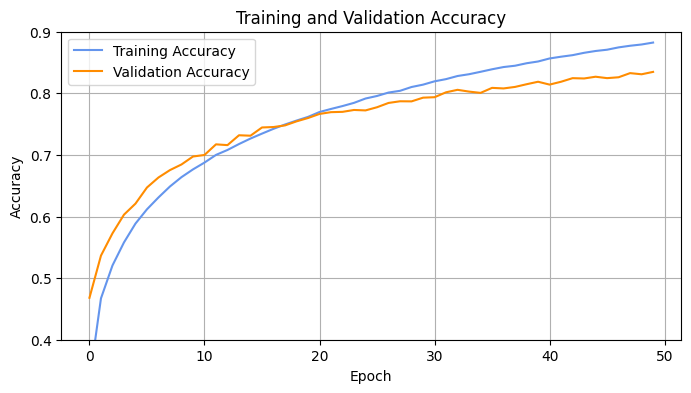

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

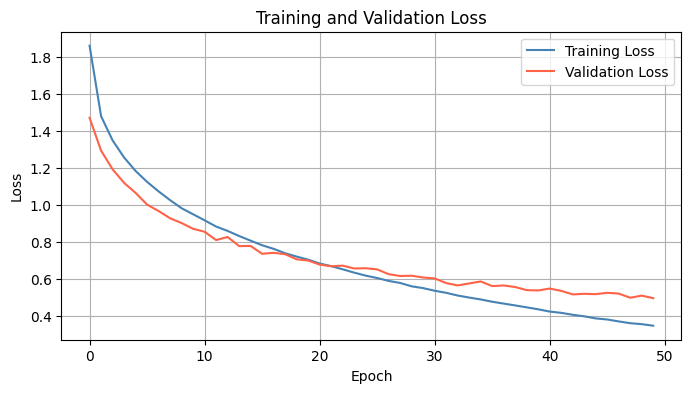

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

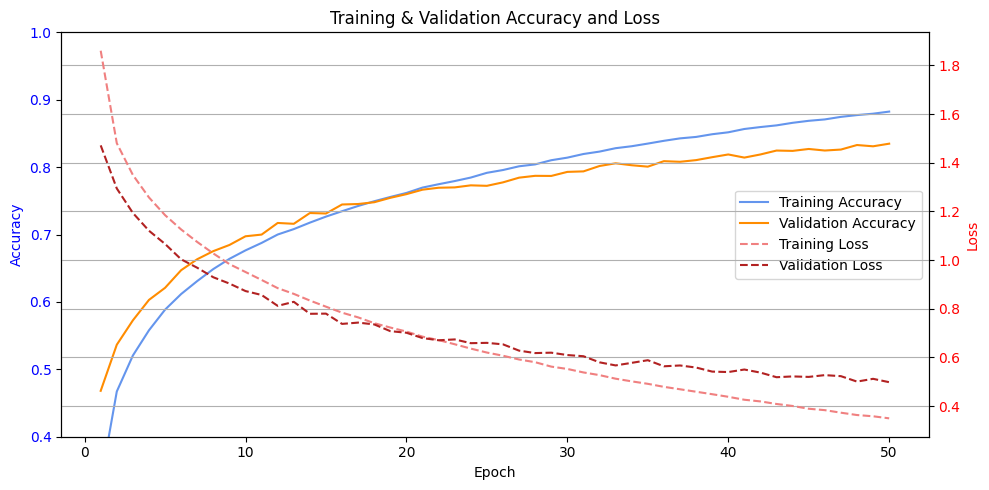

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (25% Dropout LSTM & Dense Layer, Batch Normalization)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_crnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(Dropout(0.25))
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer
    model.add(Dropout(0.25))

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))  # Dropout 30% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_25drop_5seg_augmented_end.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.2232 - loss: 2.1371 - val_accuracy: 0.4185 - val_loss: 1.5842
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.4315 - loss: 1.5907 - val_accuracy: 0.4891 - val_loss: 1.3956
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4778 - loss: 1.4412 - val_accuracy: 0.5430 - val_loss: 1.2505
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5124 - loss: 1.3710 - val_accuracy: 0.5752 - val_loss: 1.1890
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5477 - loss: 1.2916 - val_accuracy: 0.5936 - val_loss: 1.1524
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5722 - loss: 1.2291 - val_accuracy: 0.6274 - val_loss: 1.0709
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5951 - loss: 1.1748 - val_accuracy: 0.6324 - val_loss: 1.0338
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.6020 - loss: 1.1412 - 

Fold 1 Precision: 0.8120
Fold 1 Recall: 0.8108
Fold 1 F1-Score: 0.8101
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8270, Val Acc: 0.8099)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.8099 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.2238 - loss: 2.1231 - val_accuracy: 0.4198 - val_loss: 1.5458
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4088 - loss: 1.6102 - val_accuracy: 0.5025 - val_loss: 1.3642
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4723 - loss: 1.4601 - val_accuracy: 0.5518 - val_loss: 1.2317
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5118 - loss: 1.3603 - val_accuracy: 0.5931 - val_loss: 1.1519
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5509 - loss: 1.2871 - val_accuracy: 0.6132 - val_loss: 1.1032
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.5724 - loss: 1.2339 - val_accuracy: 0.6253 - val_loss: 1.0777
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.6011 - loss: 1.1641 - val_accuracy: 0.6479 - val_loss: 1.0018
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6129 - loss: 1.1284 - 

Fold 2 Precision: 0.8297
Fold 2 Recall: 0.8285
Fold 2 F1-Score: 0.8276
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8382, Val Acc: 0.8279)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8279 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.2257 - loss: 2.1372 - val_accuracy: 0.4127 - val_loss: 1.5474
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4251 - loss: 1.5905 - val_accuracy: 0.5272 - val_loss: 1.3373
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.4843 - loss: 1.4203 - val_accuracy: 0.5664 - val_loss: 1.2258
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.5243 - loss: 1.3262 - val_accuracy: 0.5957 - val_loss: 1.1582
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5594 - loss: 1.2540 - val_accuracy: 0.6132 - val_loss: 1.1202
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5811 - loss: 1.2082 - val_accuracy: 0.6412 - val_loss: 1.0391
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6071 - loss: 1.1462 - val_accuracy: 0.6470 - val_loss: 1.0136
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.6199 - loss: 1.1048 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.2087 - loss: 2.1566 - val_accuracy: 0.4215 - val_loss: 1.5792
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.4139 - loss: 1.6374 - val_accuracy: 0.5084 - val_loss: 1.3748
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4661 - loss: 1.4841 - val_accuracy: 0.5518 - val_loss: 1.2545
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5095 - loss: 1.3686 - val_accuracy: 0.5848 - val_loss: 1.1703
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.5470 - loss: 1.2838 - val_accuracy: 0.6186 - val_loss: 1.0824
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.5812 - loss: 1.2103 - val_accuracy: 0.6412 - val_loss: 1.0302
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6054 - loss: 1.1628 - val_accuracy: 0.6441 - val_loss: 1.0102
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6284 - loss: 1.1028 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.2086 - loss: 2.1511 - val_accuracy: 0.4490 - val_loss: 1.5407
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4323 - loss: 1.5866 - val_accuracy: 0.5217 - val_loss: 1.3455
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4865 - loss: 1.4456 - val_accuracy: 0.5606 - val_loss: 1.2534
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.5351 - loss: 1.3414 - val_accuracy: 0.5998 - val_loss: 1.1630
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.5609 - loss: 1.2813 - val_accuracy: 0.6170 - val_loss: 1.0891
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6004 - loss: 1.1937 - val_accuracy: 0.6462 - val_loss: 1.0333
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6104 - loss: 1.1418 - val_accuracy: 0.6650 - val_loss: 1.0002
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.6370 - loss: 1.0927 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.2483 - loss: 2.0922 - val_accuracy: 0.4574 - val_loss: 1.4939
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.4325 - loss: 1.5591 - val_accuracy: 0.5075 - val_loss: 1.3354
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.4825 - loss: 1.4226 - val_accuracy: 0.5744 - val_loss: 1.2005
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.5292 - loss: 1.3187 - val_accuracy: 0.6048 - val_loss: 1.1239
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5566 - loss: 1.2600 - val_accuracy: 0.6299 - val_loss: 1.0777
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.5882 - loss: 1.2017 - val_accuracy: 0.6491 - val_loss: 0.9968
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6084 - loss: 1.1380 - val_accuracy: 0.6708 - val_loss: 0.9598
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6286 - loss: 1.0978 - 

Fold 6 Precision: 0.8335
Fold 6 Recall: 0.8328
Fold 6 F1-Score: 0.8311
✅ Fold 6 memiliki generalisasi yang **baik** (Train Acc: 0.8453, Val Acc: 0.8346)
✅ Model terbaik disimpan dari Fold 6 dengan akurasi 0.8346 dan generalisasi yang baik

===== Fold 7/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.2254 - loss: 2.1170 - val_accuracy: 0.4407 - val_loss: 1.5574
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.4199 - loss: 1.6087 - val_accuracy: 0.5543 - val_loss: 1.2809
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.4970 - loss: 1.4035 - val_accuracy: 0.6065 - val_loss: 1.1556
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5446 - loss: 1.3025 - val_accuracy: 0.6287 - val_loss: 1.0642
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - accuracy: 0.5773 - loss: 1.2313 - val_accuracy: 0.6412 - val_loss: 1.0325
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.6035 - loss: 1.1684 - val_accuracy: 0.6629 - val_loss: 0.9600
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6126 - loss: 1.1249 - val_accuracy: 0.6888 - val_loss: 0.9292
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.6400 - loss: 1.0717 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.2344 - loss: 2.1229 - val_accuracy: 0.4461 - val_loss: 1.5796
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.4301 - loss: 1.5937 - val_accuracy: 0.5255 - val_loss: 1.3186
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.4893 - loss: 1.4246 - val_accuracy: 0.5593 - val_loss: 1.2039
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5318 - loss: 1.3369 - val_accuracy: 0.5852 - val_loss: 1.1523
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.5582 - loss: 1.2539 - val_accuracy: 0.6195 - val_loss: 1.0819
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - accuracy: 0.5857 - loss: 1.1914 - val_accuracy: 0.6416 - val_loss: 1.0174
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6071 - loss: 1.1369 - val_accuracy: 0.6378 - val_loss: 0.9916
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6313 - loss: 1.0894 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.2352 - loss: 2.1430 - val_accuracy: 0.3860 - val_loss: 1.6446
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.4042 - loss: 1.6511 - val_accuracy: 0.5175 - val_loss: 1.3339
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4689 - loss: 1.4680 - val_accuracy: 0.5710 - val_loss: 1.2222
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5210 - loss: 1.3497 - val_accuracy: 0.6040 - val_loss: 1.1322
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5478 - loss: 1.2792 - val_accuracy: 0.6341 - val_loss: 1.0696
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5696 - loss: 1.2263 - val_accuracy: 0.6399 - val_loss: 1.0331
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.5894 - loss: 1.1807 - val_accuracy: 0.6688 - val_loss: 0.9965
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.6060 - loss: 1.1297 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.2167 - loss: 2.1468 - val_accuracy: 0.4211 - val_loss: 1.5943
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.4166 - loss: 1.6348 - val_accuracy: 0.5351 - val_loss: 1.3377
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.4857 - loss: 1.4672 - val_accuracy: 0.5731 - val_loss: 1.1994
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5322 - loss: 1.3357 - val_accuracy: 0.5844 - val_loss: 1.1629
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.5586 - loss: 1.2766 - val_accuracy: 0.6053 - val_loss: 1.1128
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5852 - loss: 1.2050 - val_accuracy: 0.6140 - val_loss: 1.0874
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.6193 - loss: 1.1373 - val_accuracy: 0.6420 - val_loss: 1.0170
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6342 - loss: 1.0952 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8180 ± 0.0084
Precision: 0.8196 ± 0.0080
Recall: 0.8181 ± 0.0091
F1-Score: 0.8169 ± 0.0084


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8378
Rata-rata Akurasi Validasi Terakhir: 0.8180
Gap Akurasi: 0.0198
✅ Model memiliki generalisasi yang **baik**.


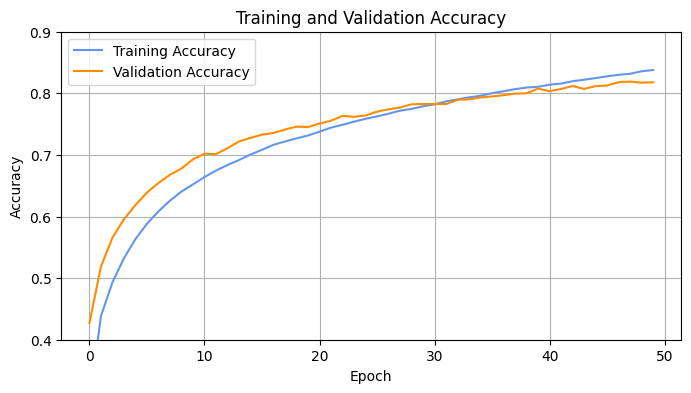

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

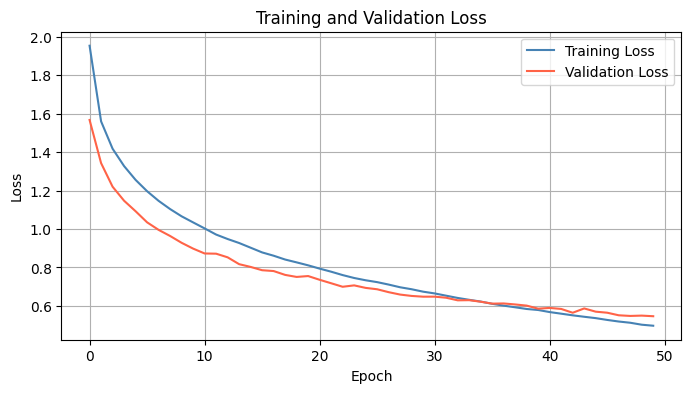

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

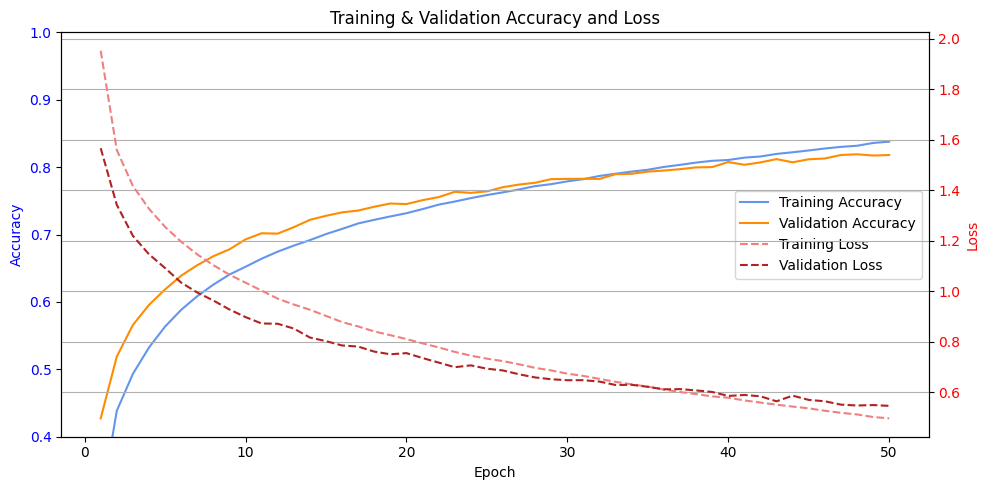

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (25% Dropout LSTM & Dense Layer, Batch Normalization, Regulation)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_crnn_model(input_shape, num_classes):
    model = Sequential()
    weight_decay = 1e-4  # Nilai regulasi L2

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(Dropout(0.25))
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer
    model.add(Dropout(0.25))

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))  # Dropout 30% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_25drop_5seg_augmented_end.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.2382 - loss: 2.1010 - val_accuracy: 0.4223 - val_loss: 1.6003
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.4152 - loss: 1.6254 - val_accuracy: 0.5129 - val_loss: 1.3657
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4880 - loss: 1.4421 - val_accuracy: 0.5443 - val_loss: 1.2722
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5319 - loss: 1.3435 - val_accuracy: 0.5877 - val_loss: 1.1643
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5703 - loss: 1.2534 - val_accuracy: 0.5986 - val_loss: 1.1280
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5841 - loss: 1.2177 - val_accuracy: 0.6174 - val_loss: 1.1049
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.6078 - loss: 1.1613 - val_accuracy: 0.6433 - val_loss: 1.0516
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.6134 - loss: 1.1224 - 

Fold 1 Precision: 0.8235
Fold 1 Recall: 0.8214
Fold 1 F1-Score: 0.8218
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8330, Val Acc: 0.8216)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.8216 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.2308 - loss: 2.1154 - val_accuracy: 0.4198 - val_loss: 1.5686
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.4089 - loss: 1.6092 - val_accuracy: 0.4992 - val_loss: 1.3530
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.4683 - loss: 1.4550 - val_accuracy: 0.5334 - val_loss: 1.2770
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.5062 - loss: 1.3805 - val_accuracy: 0.5748 - val_loss: 1.1792
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.5336 - loss: 1.3140 - val_accuracy: 0.6007 - val_loss: 1.1032
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5641 - loss: 1.2371 - val_accuracy: 0.6278 - val_loss: 1.0573
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5910 - loss: 1.1833 - val_accuracy: 0.6362 - val_loss: 1.0353
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.6171 - loss: 1.1165 - 

Fold 2 Precision: 0.8247
Fold 2 Recall: 0.8265
Fold 2 F1-Score: 0.8228
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8395, Val Acc: 0.8250)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8250 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.2256 - loss: 2.1488 - val_accuracy: 0.4240 - val_loss: 1.6045
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.4147 - loss: 1.6391 - val_accuracy: 0.5117 - val_loss: 1.3793
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.4859 - loss: 1.4446 - val_accuracy: 0.5380 - val_loss: 1.2870
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5262 - loss: 1.3498 - val_accuracy: 0.5873 - val_loss: 1.1841
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5620 - loss: 1.2664 - val_accuracy: 0.6023 - val_loss: 1.1341
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5834 - loss: 1.2140 - val_accuracy: 0.6253 - val_loss: 1.0746
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.6042 - loss: 1.1585 - val_accuracy: 0.6374 - val_loss: 1.0396
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.6252 - loss: 1.1159 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.2245 - loss: 2.1315 - val_accuracy: 0.4336 - val_loss: 1.5721
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.4114 - loss: 1.6162 - val_accuracy: 0.5188 - val_loss: 1.3576
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.4806 - loss: 1.4465 - val_accuracy: 0.5581 - val_loss: 1.2339
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5285 - loss: 1.3291 - val_accuracy: 0.5961 - val_loss: 1.1429
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5562 - loss: 1.2672 - val_accuracy: 0.6182 - val_loss: 1.0818
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.5971 - loss: 1.1807 - val_accuracy: 0.6395 - val_loss: 1.0374
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.6135 - loss: 1.1499 - val_accuracy: 0.6504 - val_loss: 1.0002
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6293 - loss: 1.0966 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.2512 - loss: 2.1298 - val_accuracy: 0.4357 - val_loss: 1.5536
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.4303 - loss: 1.5917 - val_accuracy: 0.5013 - val_loss: 1.3712
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4810 - loss: 1.4512 - val_accuracy: 0.5455 - val_loss: 1.2691
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5097 - loss: 1.3743 - val_accuracy: 0.5785 - val_loss: 1.1992
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5477 - loss: 1.2955 - val_accuracy: 0.6011 - val_loss: 1.1405
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5731 - loss: 1.2424 - val_accuracy: 0.6157 - val_loss: 1.0842
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5871 - loss: 1.2053 - val_accuracy: 0.6266 - val_loss: 1.0705
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.6086 - loss: 1.1562 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.2393 - loss: 2.1196 - val_accuracy: 0.4252 - val_loss: 1.5693
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.4012 - loss: 1.6363 - val_accuracy: 0.4992 - val_loss: 1.3915
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.4606 - loss: 1.4786 - val_accuracy: 0.5606 - val_loss: 1.2376
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.5164 - loss: 1.3634 - val_accuracy: 0.5789 - val_loss: 1.1957
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5427 - loss: 1.2981 - val_accuracy: 0.6128 - val_loss: 1.0972
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5678 - loss: 1.2406 - val_accuracy: 0.6332 - val_loss: 1.0458
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.5878 - loss: 1.1938 - val_accuracy: 0.6520 - val_loss: 1.0112
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.6139 - loss: 1.1356 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.2117 - loss: 2.1602 - val_accuracy: 0.4190 - val_loss: 1.6263
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.4197 - loss: 1.6106 - val_accuracy: 0.5088 - val_loss: 1.3645
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.4800 - loss: 1.4536 - val_accuracy: 0.5576 - val_loss: 1.2306
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5140 - loss: 1.3608 - val_accuracy: 0.5982 - val_loss: 1.1248
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5502 - loss: 1.2684 - val_accuracy: 0.6241 - val_loss: 1.0616
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5740 - loss: 1.2364 - val_accuracy: 0.6420 - val_loss: 1.0132
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6017 - loss: 1.1760 - val_accuracy: 0.6404 - val_loss: 1.0125
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.6116 - loss: 1.1357 - 

Fold 7 Precision: 0.8314
Fold 7 Recall: 0.8325
Fold 7 F1-Score: 0.8316
✅ Fold 7 memiliki generalisasi yang **baik** (Train Acc: 0.8347, Val Acc: 0.8317)
✅ Model terbaik disimpan dari Fold 7 dengan akurasi 0.8317 dan generalisasi yang baik

===== Fold 8/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.2366 - loss: 2.1288 - val_accuracy: 0.4482 - val_loss: 1.5594
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.4249 - loss: 1.6112 - val_accuracy: 0.4912 - val_loss: 1.4075
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.4867 - loss: 1.4512 - val_accuracy: 0.5535 - val_loss: 1.2478
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5287 - loss: 1.3628 - val_accuracy: 0.5748 - val_loss: 1.2099
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5634 - loss: 1.2753 - val_accuracy: 0.5994 - val_loss: 1.1293
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5916 - loss: 1.2064 - val_accuracy: 0.6362 - val_loss: 1.0571
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6039 - loss: 1.1710 - val_accuracy: 0.6550 - val_loss: 0.9930
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6254 - loss: 1.1206 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.2317 - loss: 2.1446 - val_accuracy: 0.4486 - val_loss: 1.5644
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.4060 - loss: 1.6229 - val_accuracy: 0.5159 - val_loss: 1.3478
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4578 - loss: 1.4845 - val_accuracy: 0.5606 - val_loss: 1.2295
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4925 - loss: 1.3784 - val_accuracy: 0.5877 - val_loss: 1.1681
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5256 - loss: 1.3292 - val_accuracy: 0.6107 - val_loss: 1.1019
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.5528 - loss: 1.2740 - val_accuracy: 0.6203 - val_loss: 1.0807
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.5817 - loss: 1.2065 - val_accuracy: 0.6399 - val_loss: 1.0199
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.5990 - loss: 1.1643 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.2226 - loss: 2.1415 - val_accuracy: 0.4553 - val_loss: 1.5216
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.4239 - loss: 1.6042 - val_accuracy: 0.5330 - val_loss: 1.3230
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.4875 - loss: 1.4377 - val_accuracy: 0.5764 - val_loss: 1.2207
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5312 - loss: 1.3443 - val_accuracy: 0.5940 - val_loss: 1.1497
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5452 - loss: 1.2837 - val_accuracy: 0.5990 - val_loss: 1.1509
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5742 - loss: 1.2346 - val_accuracy: 0.6341 - val_loss: 1.0475
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6047 - loss: 1.1687 - val_accuracy: 0.6495 - val_loss: 1.0157
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.6216 - loss: 1.1224 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8216 ± 0.0070
Precision: 0.8249 ± 0.0054
Recall: 0.8219 ± 0.0071
F1-Score: 0.8211 ± 0.0068


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8340
Rata-rata Akurasi Validasi Terakhir: 0.8216
Gap Akurasi: 0.0124
✅ Model memiliki generalisasi yang **baik**.


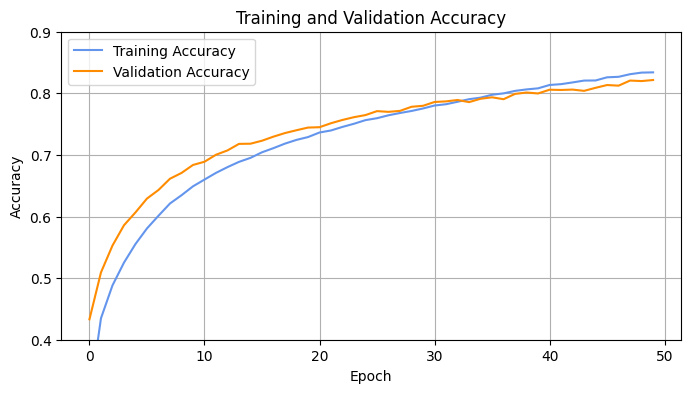

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

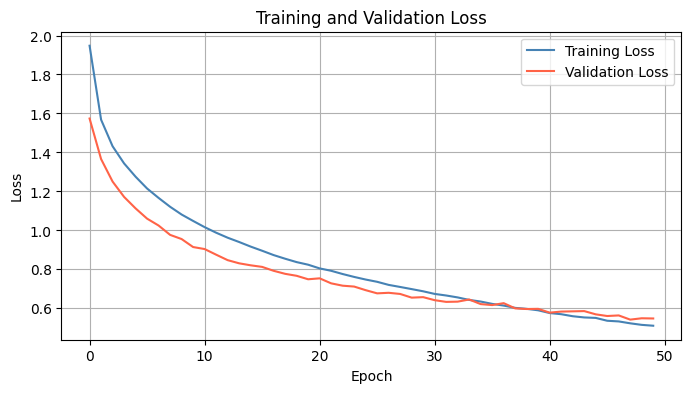

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

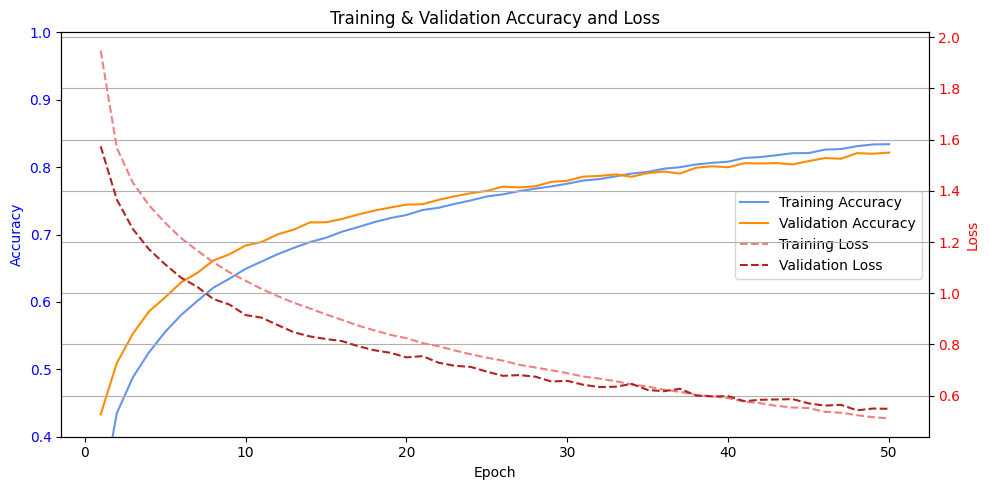

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (25% Droout LSTM & Dese Layer, Batch Normalization, Regulation CNN & Dense Layer)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_crnn_model(input_shape, num_classes):
    model = Sequential()
    weight_decay = 1e-4  # Nilai regulasi L2

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (128 units)
    model.add(LSTM(128, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(Dropout(0.25))
    model.add(LSTM(128))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer
    model.add(Dropout(0.25))

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))  # Dense untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_25drop_5seg_augmented_cnndensereg.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.2256 - loss: 2.1498 - val_accuracy: 0.3910 - val_loss: 1.6440
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.3864 - loss: 1.6778 - val_accuracy: 0.4858 - val_loss: 1.3991
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.4629 - loss: 1.5071 - val_accuracy: 0.5522 - val_loss: 1.2829
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5038 - loss: 1.3974 - val_accuracy: 0.5593 - val_loss: 1.2146
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.5335 - loss: 1.3273 - val_accuracy: 0.5911 - val_loss: 1.1553
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5758 - loss: 1.2382 - val_accuracy: 0.6145 - val_loss: 1.1031
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.5877 - loss: 1.2118 - val_accuracy: 0.6253 - val_loss: 1.0708
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.6098 - loss: 1.1532 - 

Fold 1 Precision: 0.8035
Fold 1 Recall: 0.8013
Fold 1 F1-Score: 0.8006
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8235, Val Acc: 0.8012)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.8012 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - accuracy: 0.2086 - loss: 2.1735 - val_accuracy: 0.4290 - val_loss: 1.6342
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.4326 - loss: 1.6387 - val_accuracy: 0.4967 - val_loss: 1.4195
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.4869 - loss: 1.4775 - val_accuracy: 0.5468 - val_loss: 1.2735
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5161 - loss: 1.3748 - val_accuracy: 0.5756 - val_loss: 1.2334
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5501 - loss: 1.2958 - val_accuracy: 0.6048 - val_loss: 1.1325
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5758 - loss: 1.2443 - val_accuracy: 0.6253 - val_loss: 1.0803
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.6046 - loss: 1.1815 - val_accuracy: 0.6124 - val_loss: 1.0991
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.6143 - loss: 1.1437 - 

Fold 2 Precision: 0.8356
Fold 2 Recall: 0.8301
Fold 2 F1-Score: 0.8291
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8417, Val Acc: 0.8292)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8292 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.2365 - loss: 2.1593 - val_accuracy: 0.4185 - val_loss: 1.5779
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4231 - loss: 1.6116 - val_accuracy: 0.5284 - val_loss: 1.3934
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.4893 - loss: 1.4517 - val_accuracy: 0.5489 - val_loss: 1.2928
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5176 - loss: 1.3697 - val_accuracy: 0.5702 - val_loss: 1.2339
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5483 - loss: 1.3118 - val_accuracy: 0.5869 - val_loss: 1.1602
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5736 - loss: 1.2423 - val_accuracy: 0.6178 - val_loss: 1.1067
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.5846 - loss: 1.1978 - val_accuracy: 0.6312 - val_loss: 1.0924
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.6011 - loss: 1.1672 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.2143 - loss: 2.1771 - val_accuracy: 0.4282 - val_loss: 1.6468
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.4029 - loss: 1.6729 - val_accuracy: 0.5121 - val_loss: 1.3893
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4640 - loss: 1.5048 - val_accuracy: 0.5459 - val_loss: 1.2724
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4990 - loss: 1.4206 - val_accuracy: 0.5764 - val_loss: 1.2010
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.5371 - loss: 1.3224 - val_accuracy: 0.6023 - val_loss: 1.1389
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.5673 - loss: 1.2644 - val_accuracy: 0.6303 - val_loss: 1.0786
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.5924 - loss: 1.2158 - val_accuracy: 0.6399 - val_loss: 1.0442
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.6105 - loss: 1.1757 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.2596 - loss: 2.1398 - val_accuracy: 0.4344 - val_loss: 1.5840
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.4334 - loss: 1.6109 - val_accuracy: 0.5401 - val_loss: 1.3466
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.5052 - loss: 1.4390 - val_accuracy: 0.5702 - val_loss: 1.2411
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.5486 - loss: 1.3231 - val_accuracy: 0.5990 - val_loss: 1.1585
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5757 - loss: 1.2579 - val_accuracy: 0.6216 - val_loss: 1.1052
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5914 - loss: 1.2013 - val_accuracy: 0.6307 - val_loss: 1.0691
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6137 - loss: 1.1603 - val_accuracy: 0.6596 - val_loss: 1.0150
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.6296 - loss: 1.1221 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.2357 - loss: 2.1289 - val_accuracy: 0.4231 - val_loss: 1.5845
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.4181 - loss: 1.6109 - val_accuracy: 0.5188 - val_loss: 1.3582
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.4856 - loss: 1.4569 - val_accuracy: 0.5664 - val_loss: 1.2396
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5248 - loss: 1.3690 - val_accuracy: 0.6023 - val_loss: 1.1632
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5599 - loss: 1.2879 - val_accuracy: 0.6211 - val_loss: 1.1114
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5827 - loss: 1.2314 - val_accuracy: 0.6307 - val_loss: 1.0638
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5987 - loss: 1.1907 - val_accuracy: 0.6508 - val_loss: 1.0152
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.6129 - loss: 1.1467 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.2138 - loss: 2.1787 - val_accuracy: 0.4570 - val_loss: 1.5365
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.4281 - loss: 1.6052 - val_accuracy: 0.5263 - val_loss: 1.3413
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4839 - loss: 1.4615 - val_accuracy: 0.5702 - val_loss: 1.2278
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.5305 - loss: 1.3470 - val_accuracy: 0.6019 - val_loss: 1.1529
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5561 - loss: 1.2804 - val_accuracy: 0.6161 - val_loss: 1.1240
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5811 - loss: 1.2235 - val_accuracy: 0.6449 - val_loss: 1.0326
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.6008 - loss: 1.1840 - val_accuracy: 0.6458 - val_loss: 1.0261
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.6089 - loss: 1.1538 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.2379 - loss: 2.1596 - val_accuracy: 0.3872 - val_loss: 1.6606
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.4204 - loss: 1.6328 - val_accuracy: 0.5142 - val_loss: 1.3704
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.4851 - loss: 1.4655 - val_accuracy: 0.5693 - val_loss: 1.2378
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.5280 - loss: 1.3541 - val_accuracy: 0.6003 - val_loss: 1.1558
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5651 - loss: 1.2818 - val_accuracy: 0.6341 - val_loss: 1.1210
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.5965 - loss: 1.2070 - val_accuracy: 0.6537 - val_loss: 1.0451
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.6088 - loss: 1.1644 - val_accuracy: 0.6671 - val_loss: 0.9901
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.6326 - loss: 1.1118 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.2190 - loss: 2.1546 - val_accuracy: 0.4741 - val_loss: 1.4976
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.4372 - loss: 1.6099 - val_accuracy: 0.5363 - val_loss: 1.3198
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4780 - loss: 1.4618 - val_accuracy: 0.5744 - val_loss: 1.2257
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5149 - loss: 1.3782 - val_accuracy: 0.5944 - val_loss: 1.1724
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5451 - loss: 1.3151 - val_accuracy: 0.6216 - val_loss: 1.1184
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.5773 - loss: 1.2427 - val_accuracy: 0.6529 - val_loss: 1.0592
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5978 - loss: 1.1893 - val_accuracy: 0.6642 - val_loss: 0.9991
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.6242 - loss: 1.1530 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.2362 - loss: 2.1479 - val_accuracy: 0.4495 - val_loss: 1.5891
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.4235 - loss: 1.6321 - val_accuracy: 0.5439 - val_loss: 1.3097
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5006 - loss: 1.4314 - val_accuracy: 0.5764 - val_loss: 1.2076
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.5343 - loss: 1.3424 - val_accuracy: 0.5890 - val_loss: 1.1744
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.5605 - loss: 1.2830 - val_accuracy: 0.6128 - val_loss: 1.1259
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - accuracy: 0.5960 - loss: 1.2099 - val_accuracy: 0.6424 - val_loss: 1.0408
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.6257 - loss: 1.1341 - val_accuracy: 0.6583 - val_loss: 0.9893
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.6355 - loss: 1.0987 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.8186 ± 0.0085
Precision: 0.8200 ± 0.0084
Recall: 0.8190 ± 0.0085
F1-Score: 0.8176 ± 0.0082


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8352
Rata-rata Akurasi Validasi Terakhir: 0.8186
Gap Akurasi: 0.0165
✅ Model memiliki generalisasi yang **baik**.


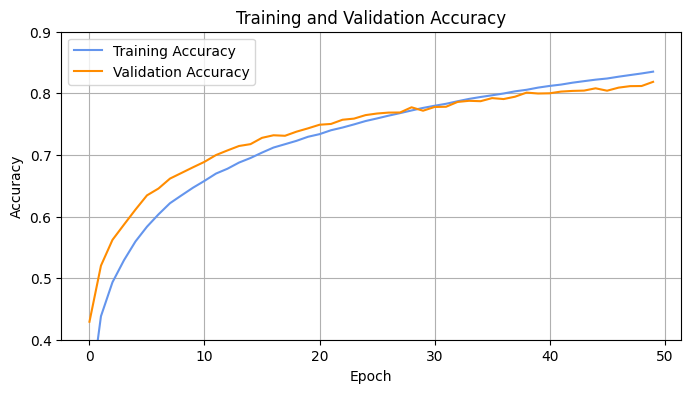

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

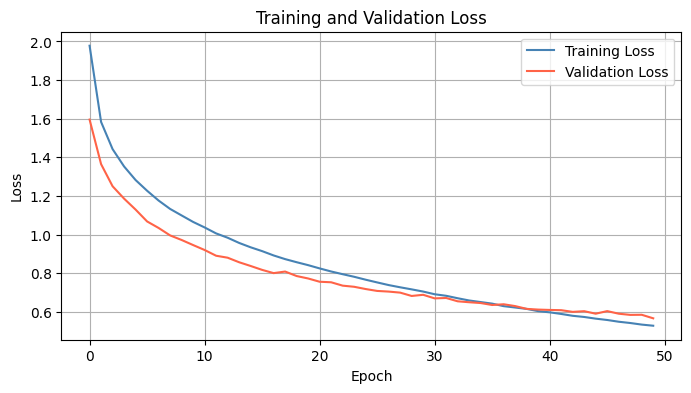

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

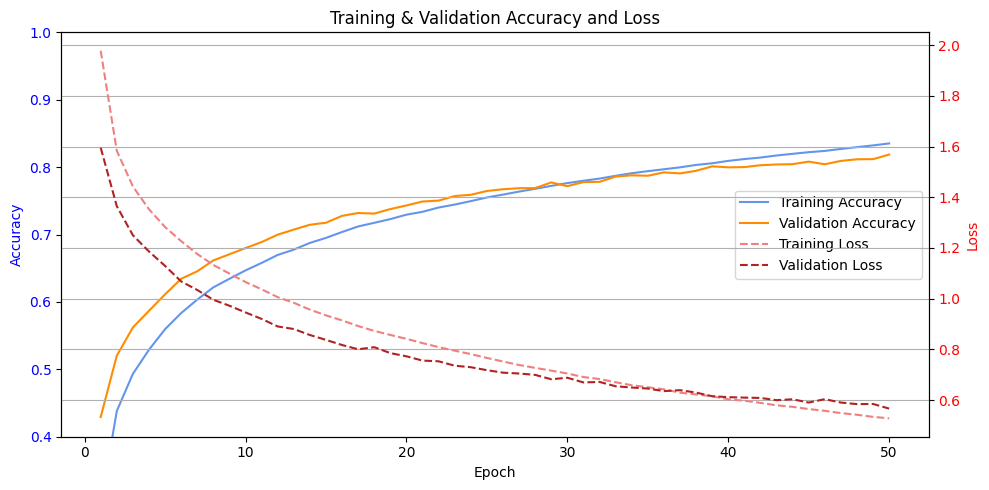

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

### CRNN Model (25% Dropout LSTM & Dense Layer, Batch Normalization, Regulation, LSTM 64 filter)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_crnn_model(input_shape, num_classes):
    model = Sequential()
    weight_decay = 1e-4  # Nilai regulasi L2

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 2
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Convolutional Layer 3
    model.add(Conv2D(32, (2, 2), strides=(2,2), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Reshape layer: CNN output → LSTM input
    model.add(Reshape((model.output_shape[1], -1)))  # (time_steps, features)

    # LSTM Layers (64 units)
    model.add(LSTM(64, return_sequences=True))  # Mengirimkan output per timestep ke LSTM berikutnya
    model.add(Dropout(0.25))
    model.add(LSTM(64))  # Tanpa return_sequences, output terakhir langsung masuk ke Flatten layer
    model.add(Dropout(0.25))

    # Flatten Layer: Mengubah output LSTM menjadi 1D sebelum masuk ke Dense
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))  # Dropout 30% untuk regularisasi
    model.add(Dense(num_classes, activation='softmax'))  # Dense untuk klasifikasi 10 genre

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

print("Fungsi model siap digunakan!")

Fungsi model siap digunakan!


#### K-Fold Cross Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Menyimpan metrik setiap fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_train_accs = []
fold_val_accs = []
fold_train_losses = []
fold_val_losses = []

best_model_path = ""
best_generalization_score = float('-inf')  # Skor terbaik untuk keseimbangan

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold+1}/10 =====")

    # Split data berdasarkan indeks
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Buat model
    model = build_crnn_model(input_shape=(X_train.shape[1:]), num_classes=num_classes)

    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Simpan history loss & accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)

    # Evaluasi
    val_loss_final, val_acc_final = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} Final Accuracy: {val_acc_final:.4f}")

    # Prediksi data validasi
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Hitung Precision, Recall, dan F1-Score
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
    recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
    f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

    print(f"Fold {fold+1} Precision: {precision:.4f}")
    print(f"Fold {fold+1} Recall: {recall:.4f}")
    print(f"Fold {fold+1} F1-Score: {f1_score:.4f}")

    # Simpan metrik fold ini
    fold_accuracies.append(val_acc_final)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    # Cek apakah overfitting, underfitting, atau tidak
    train_acc_final = train_acc[-1]  # Akurasi training di epoch terakhir
    acc_gap = train_acc_final - val_acc_final  # Selisih akurasi training & validasi

    if acc_gap > 0.15:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **OVERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena overfitting
    elif train_acc_final < 0.7 and val_acc_final < 0.7:
        print(f"⚠️ Fold {fold+1} kemungkinan mengalami **UNDERFITTING** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = -1  # Beri skor rendah karena underfitting
    else:
        print(f"✅ Fold {fold+1} memiliki generalisasi yang **baik** (Train Acc: {train_acc_final:.4f}, Val Acc: {val_acc_final:.4f})")
        generalization_score = val_acc_final  # Gunakan akurasi validasi sebagai skor jika model tidak overfitting/underfitting

    # Simpan model jika memiliki generalisasi terbaik
    if generalization_score > best_generalization_score:
        best_generalization_score = generalization_score
        best_model_path = f"/content/drive/MyDrive/dataset/best_crnn_model_25drop_5seg_augmented_cnnreg_global.h5"
        model.save(best_model_path)
        print(f"✅ Model terbaik disimpan dari Fold {fold+1} dengan akurasi {val_acc_final:.4f} dan generalisasi yang baik")

print("\n🎉 Training selesai!")


===== Fold 1/10 =====
Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.2016 - loss: 2.1801 - val_accuracy: 0.3275 - val_loss: 1.7343
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.3675 - loss: 1.7147 - val_accuracy: 0.4578 - val_loss: 1.4692
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.4433 - loss: 1.5287 - val_accuracy: 0.5213 - val_loss: 1.3315
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4790 - loss: 1.4493 - val_accuracy: 0.5505 - val_loss: 1.2692
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.5229 - loss: 1.3392 - val_accuracy: 0.5702 - val_loss: 1.1910
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.5417 - loss: 1.2998 - val_accuracy: 0.5819 - val_loss: 1.1826
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5539 - loss: 1.2614 - val_accuracy: 0.6048 - val_loss: 1.1245
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0

Fold 1 Precision: 0.7915
Fold 1 Recall: 0.7929
Fold 1 F1-Score: 0.7899
✅ Fold 1 memiliki generalisasi yang **baik** (Train Acc: 0.8064, Val Acc: 0.7911)
✅ Model terbaik disimpan dari Fold 1 dengan akurasi 0.7911 dan generalisasi yang baik

===== Fold 2/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.2051 - loss: 2.2034 - val_accuracy: 0.3872 - val_loss: 1.6964
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3979 - loss: 1.6887 - val_accuracy: 0.4858 - val_loss: 1.4227
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.4548 - loss: 1.4926 - val_accuracy: 0.5142 - val_loss: 1.3357
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4935 - loss: 1.3965 - val_accuracy: 0.5493 - val_loss: 1.2631
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5252 - loss: 1.3290 - val_accuracy: 0.5785 - val_loss: 1.2055
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5451 - loss: 1.2874 - val_accuracy: 0.6140 - val_loss: 1.1143
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5696 - loss: 1.2290 - val_accuracy: 0.6228 - val_loss: 1.0922
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5900 - loss: 1.1940 - 

Fold 2 Precision: 0.7994
Fold 2 Recall: 0.8014
Fold 2 F1-Score: 0.7982
✅ Fold 2 memiliki generalisasi yang **baik** (Train Acc: 0.8069, Val Acc: 0.8003)
✅ Model terbaik disimpan dari Fold 2 dengan akurasi 0.8003 dan generalisasi yang baik

===== Fold 3/10 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.2251 - loss: 2.1594 - val_accuracy: 0.3538 - val_loss: 1.7101
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.3726 - loss: 1.6993 - val_accuracy: 0.4653 - val_loss: 1.4509
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.4518 - loss: 1.5245 - val_accuracy: 0.5363 - val_loss: 1.3113
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5042 - loss: 1.4075 - val_accuracy: 0.5610 - val_loss: 1.2528
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5226 - loss: 1.3357 - val_accuracy: 0.5919 - val_loss: 1.1722
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.5578 - loss: 1.2790 - val_accuracy: 0.5931 - val_loss: 1.1335
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5695 - loss: 1.2542 - val_accuracy: 0.6086 - val_loss: 1.1075
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5919 - loss: 1.2045 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.1773 - loss: 2.2355 - val_accuracy: 0.4002 - val_loss: 1.7073
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.3789 - loss: 1.7328 - val_accuracy: 0.5167 - val_loss: 1.3807
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.4726 - loss: 1.5019 - val_accuracy: 0.5526 - val_loss: 1.2646
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5080 - loss: 1.3880 - val_accuracy: 0.5773 - val_loss: 1.2004
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5309 - loss: 1.3338 - val_accuracy: 0.6011 - val_loss: 1.1399
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5493 - loss: 1.2884 - val_accuracy: 0.6094 - val_loss: 1.1075
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5675 - loss: 1.2391 - val_accuracy: 0.6186 - val_loss: 1.0736
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5791 - loss: 1.2075 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.1900 - loss: 2.2288 - val_accuracy: 0.3596 - val_loss: 1.7433
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.3748 - loss: 1.7244 - val_accuracy: 0.4774 - val_loss: 1.4568
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.4569 - loss: 1.5134 - val_accuracy: 0.5443 - val_loss: 1.2944
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5039 - loss: 1.3921 - val_accuracy: 0.5660 - val_loss: 1.2209
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5372 - loss: 1.3197 - val_accuracy: 0.5744 - val_loss: 1.1800
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5490 - loss: 1.2882 - val_accuracy: 0.6044 - val_loss: 1.1199
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5734 - loss: 1.2352 - val_accuracy: 0.6003 - val_loss: 1.1173
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5903 - loss: 1.1945 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.1997 - loss: 2.2006 - val_accuracy: 0.4524 - val_loss: 1.5652
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.4249 - loss: 1.6146 - val_accuracy: 0.5109 - val_loss: 1.3563
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.4759 - loss: 1.4605 - val_accuracy: 0.5815 - val_loss: 1.2213
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.5211 - loss: 1.3633 - val_accuracy: 0.5969 - val_loss: 1.1866
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.5449 - loss: 1.3023 - val_accuracy: 0.6048 - val_loss: 1.1344
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.5663 - loss: 1.2524 - val_accuracy: 0.6190 - val_loss: 1.0887
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.5876 - loss: 1.2199 - val_accuracy: 0.6441 - val_loss: 1.0320
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.6031 - loss: 1.1639 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.1960 - loss: 2.2103 - val_accuracy: 0.3613 - val_loss: 1.7798
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.3641 - loss: 1.7589 - val_accuracy: 0.4992 - val_loss: 1.4436
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.4394 - loss: 1.5471 - val_accuracy: 0.5180 - val_loss: 1.3409
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.4780 - loss: 1.4500 - val_accuracy: 0.5718 - val_loss: 1.2162
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5141 - loss: 1.3749 - val_accuracy: 0.6015 - val_loss: 1.1426
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5391 - loss: 1.3149 - val_accuracy: 0.6236 - val_loss: 1.0924
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5533 - loss: 1.2812 - val_accuracy: 0.6195 - val_loss: 1.0992
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.5721 - loss: 1.2434 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.1879 - loss: 2.2065 - val_accuracy: 0.3693 - val_loss: 1.6792
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.3816 - loss: 1.6852 - val_accuracy: 0.4937 - val_loss: 1.4063
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.4614 - loss: 1.4795 - val_accuracy: 0.5188 - val_loss: 1.3036
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.4897 - loss: 1.4101 - val_accuracy: 0.5405 - val_loss: 1.2660
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5317 - loss: 1.3302 - val_accuracy: 0.5744 - val_loss: 1.1768
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.5495 - loss: 1.2778 - val_accuracy: 0.5777 - val_loss: 1.1552
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5659 - loss: 1.2487 - val_accuracy: 0.6019 - val_loss: 1.1025
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5817 - loss: 1.2114 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.2145 - loss: 2.1822 - val_accuracy: 0.4549 - val_loss: 1.5404
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.4092 - loss: 1.6290 - val_accuracy: 0.5155 - val_loss: 1.3301
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.4624 - loss: 1.4824 - val_accuracy: 0.5581 - val_loss: 1.2329
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.4975 - loss: 1.3961 - val_accuracy: 0.5869 - val_loss: 1.1682
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5232 - loss: 1.3390 - val_accuracy: 0.6178 - val_loss: 1.1125
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.5521 - loss: 1.2595 - val_accuracy: 0.6278 - val_loss: 1.0505
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.5704 - loss: 1.2224 - val_accuracy: 0.6420 - val_loss: 1.0270
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5880 - loss: 1.1871 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.2093 - loss: 2.1893 - val_accuracy: 0.3751 - val_loss: 1.6821
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.3893 - loss: 1.6978 - val_accuracy: 0.4958 - val_loss: 1.4140
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4508 - loss: 1.5196 - val_accuracy: 0.5292 - val_loss: 1.3036
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.4783 - loss: 1.4375 - val_accuracy: 0.5530 - val_loss: 1.2490
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.5110 - loss: 1.3785 - val_accuracy: 0.5773 - val_loss: 1.2002
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5331 - loss: 1.3250 - val_accuracy: 0.5944 - val_loss: 1.1613
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.5550 - loss: 1.2792 - val_accuracy: 0.6044 - val_loss: 1.1165
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5642 - loss: 1.2537 - 

In [ ]:
print("\n===== Rata-rata hasil Cross-Validation =====")
print(f"Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


===== Rata-rata hasil Cross-Validation =====
Accuracy: 0.7863 ± 0.0129
Precision: 0.7880 ± 0.0126
Recall: 0.7868 ± 0.0127
F1-Score: 0.7841 ± 0.0144


In [ ]:
mean_train_final_acc = np.mean([train_acc[-1] for train_acc in fold_train_accs])
mean_val_final_acc = np.mean([val_acc[-1] for val_acc in fold_val_accs])
gap = mean_train_final_acc - mean_val_final_acc

print("\n===== Evaluasi Generalisasi Model =====")
print(f"Rata-rata Akurasi Training Terakhir: {mean_train_final_acc:.4f}")
print(f"Rata-rata Akurasi Validasi Terakhir: {mean_val_final_acc:.4f}")
print(f"Gap Akurasi: {gap:.4f}")

if gap > 0.15:
    print("⚠️ Model cenderung mengalami **OVERFITTING**.")
elif mean_train_final_acc < 0.7 and mean_val_final_acc < 0.7:
    print("⚠️ Model cenderung mengalami **UNDERFITTING**.")
else:
    print("✅ Model memiliki generalisasi yang **baik**.")


===== Evaluasi Generalisasi Model =====
Rata-rata Akurasi Training Terakhir: 0.8013
Rata-rata Akurasi Validasi Terakhir: 0.7863
Gap Akurasi: 0.0150
✅ Model memiliki generalisasi yang **baik**.


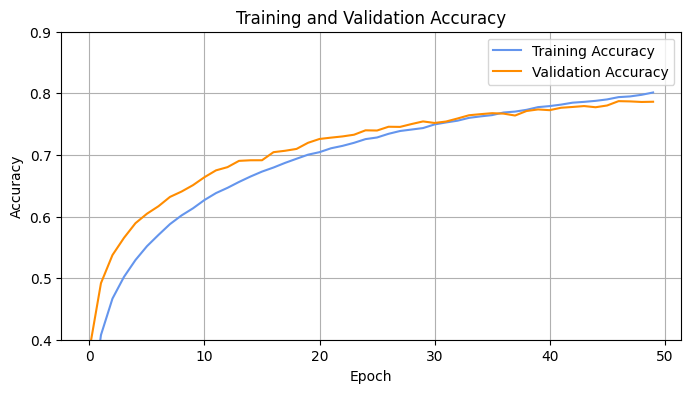

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata accuracy per epoch
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_acc, label='Training Accuracy', color='cornflowerblue')
plt.plot(avg_val_acc, label='Validation Accuracy', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.4, 0.9)
plt.show()

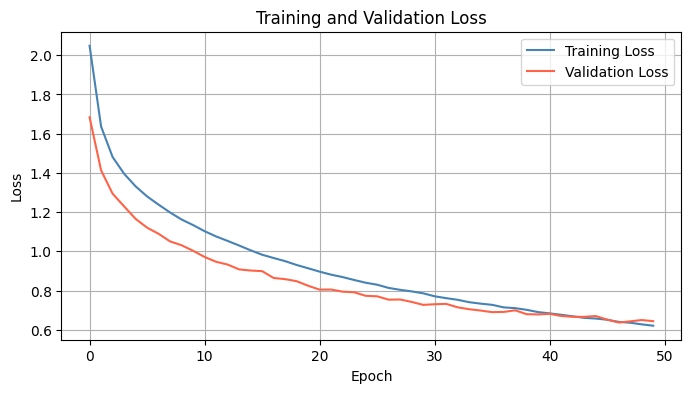

In [ ]:
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_train_loss, label='Training Loss', color='steelblue')
plt.plot(avg_val_loss, label='Validation Loss', color='tomato')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

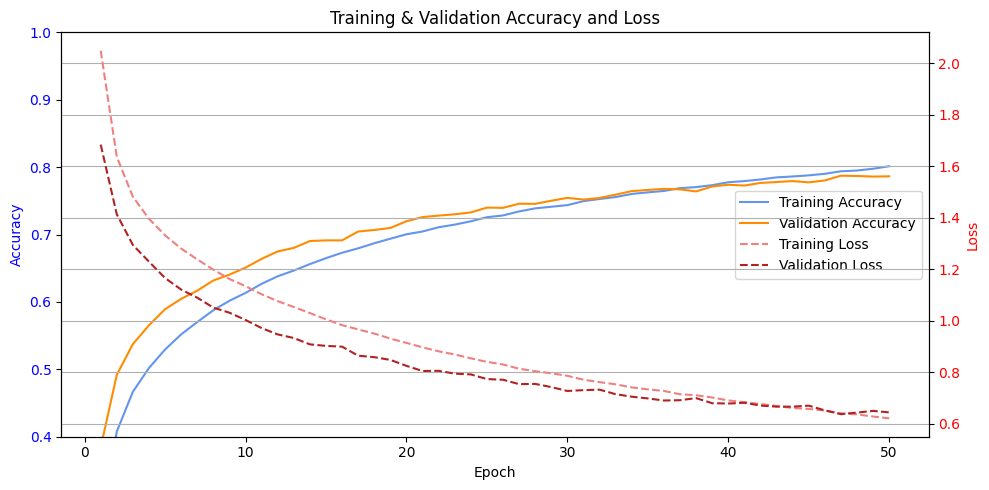

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung rata-rata
avg_train_acc = np.mean(fold_train_accs, axis=0)
avg_val_acc = np.mean(fold_val_accs, axis=0)
avg_train_loss = np.mean(fold_train_losses, axis=0)
avg_val_loss = np.mean(fold_val_losses, axis=0)

epochs = range(1, len(avg_train_acc) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (sumbu kiri)
ax1.set_title('Training & Validation Accuracy and Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, avg_train_acc, label='Training Accuracy', color='cornflowerblue')
ax1.plot(epochs, avg_val_acc, label='Validation Accuracy', color='darkorange')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.4, 1.0)

# Tambahkan sumbu kedua (Loss di sisi kanan)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, avg_train_loss, label='Training Loss', linestyle='--', color='lightcoral')
ax2.plot(epochs, avg_val_loss, label='Validation Loss', linestyle='--', color='firebrick')
ax2.tick_params(axis='y', labelcolor='red')

# Gabungkan legend dari kedua sumbu
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True)
plt.tight_layout()
plt.show()

# Pencarian Model Terbaik Dari Hasil Testing 3

## Feature Exctraction with MFCC & 5 Sec Segmentation

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

# Path ke folder dataset
general_path = '/content/drive/MyDrive/dataset/genres_augmented'
output_csv = '/content/drive/MyDrive/dataset/segmented_audio_5s.csv'
output_json = '/content/drive/MyDrive/dataset/segmented_audio_5s.json'
output_npy = '/content/drive/MyDrive/dataset/mfcc_dataset.npz'  # File npz untuk menyimpan semua data MFCC

# Parameter segmentasi dan ekstraksi fitur
segment_duration = 5  # Durasi segmentasi dalam detik
n_mfcc = 13  # Jumlah MFCC yang diekstrak
n_fft = 2048
hop_length = 512

# Menampung hasil segmentasi
X, y = [], []
data_segments = []
genre_to_label = {}

# Loop melalui setiap genre
genres = os.listdir(general_path)
for genre in genres:
    genre_dir = os.path.join(general_path, genre)
    if os.path.isdir(genre_dir):
        print(f"Memproses genre: {genre}")

        # Mapping genre ke angka
        if genre not in genre_to_label:
            genre_to_label[genre] = len(genre_to_label)

        # Loop melalui setiap file dalam genre
        for filename in tqdm(os.listdir(genre_dir)):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_dir, filename)

                try:
                    # Load audio file
                    data, sr = librosa.load(file_path, sr=None)

                    # Segmentasi audio
                    segment_length = int(segment_duration * sr)
                    num_segments = len(data) // segment_length

                    # Proses setiap segmen
                    for idx in range(num_segments):
                        start_sample = idx * segment_length
                        finish_sample = start_sample + segment_length
                        segment = data[start_sample:finish_sample]

                        if len(segment) == segment_length:
                            # Ekstraksi MFCC (format 2D)
                            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc,
                                                        n_fft=n_fft, hop_length=hop_length)
                            mfcc = mfcc.T  # Transpose agar (time_steps, n_mfcc)

                            # Simpan ke array
                            X.append(mfcc)
                            y.append(genre_to_label[genre])

                            # Simpan informasi segmen
                            segment_info = {
                                'genre': genre,
                                'filename': filename,
                                'segment_index': idx + 1,
                                'mfcc_shape': mfcc.shape,  # (time_steps, n_mfcc)
                                'genre_label': genre_to_label[genre]
                            }
                            data_segments.append(segment_info)

                except Exception as e:
                    print(f"Kesalahan saat memproses {file_path}: {e}")

# Konversi ke array numpy
X = np.array(X)[..., np.newaxis]  # Shape: (num_samples, time_steps, n_mfcc, 1)
y = np.array(y)  # Label dalam bentuk angka

# Simpan dataset dalam satu file .npz
np.savez(output_npy, X=X, y=y)
print(f"Dataset MFCC disimpan dalam satu file: {output_npy}")

# Simpan hasil ke CSV
csv_data = pd.DataFrame(data_segments)
csv_data.to_csv(output_csv, index=False)
print(f"Hasil segmentasi disimpan ke: {output_csv}")

# Simpan hasil ke JSON
with open(output_json, 'w') as json_file:
    json.dump(data_segments, json_file, indent=4)
print(f"Hasil segmentasi disimpan ke: {output_json}")

### Load Data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# === LOAD DATA ===
npz_path = "/content/drive/MyDrive/dataset/mfcc_dataset.npz"

# Muat dataset dari file .npz
data = np.load(npz_path)
X = data["X"]  # Shape: (num_samples, time_steps, n_mfcc, 1)
y = data["y"]  # Shape: (num_samples,)

# One-hot encoding untuk label genre
num_classes = len(np.unique(y))  # Hitung jumlah kelas unik dalam y
y_categorical = to_categorical(y, num_classes)

print("Dataset berhasil dimuat!")
print(f"Shape X: {X.shape}, Shape y: {y_categorical.shape}")

Dataset berhasil dimuat!
Shape X: (23940, 216, 13, 1), Shape y: (23940, 10)


In [ ]:
import json
import numpy as np
from tensorflow.keras.utils import to_categorical

# Path ke file JSON yang menyimpan informasi segmentasi
json_path = "/content/drive/MyDrive/dataset/segmented_audio_5s.json"

# Muat informasi segmentasi
with open(json_path, "r") as json_file:
    data_segments = json.load(json_file)

# Buat kembali genre_to_label dari data segmentasi
genre_to_label = {segment["genre"]: segment["genre_label"] for segment in data_segments}

# Tampilkan isi genre_to_label
print("Mapping Genre ke Label:")
for genre, label in genre_to_label.items():
    print(f"{genre}: {label}")

# === LOAD DATA ===
npz_path = "/content/drive/MyDrive/dataset/mfcc_dataset.npz"

# Muat dataset dari file .npz
data = np.load(npz_path)
X = data["X"]  # Shape: (num_samples, time_steps, n_mfcc, 1)
y = data["y"]  # Shape: (num_samples,)

# One-hot encoding untuk label genre
num_classes = len(np.unique(y))  # Hitung jumlah kelas unik dalam y
y_categorical = to_categorical(y, num_classes)

print("\nDataset berhasil dimuat!")
print(f"Shape X: {X.shape}, Shape y: {y_categorical.shape}")

Mapping Genre ke Label:
hiphop: 0
country: 1
classical: 2
rock: 3
pop: 4
jazz: 5
reggae: 6
disco: 7
blues: 8
metal: 9

Dataset berhasil dimuat!
Shape X: (23940, 216, 13, 1), Shape y: (23940, 10)


#### Model Summary

In [ ]:
input_shape = X.shape[1:]  # Ambil shape: (time_steps, n_mfcc, 1)
print("Input shape untuk model:", input_shape)

num_classes = y_categorical.shape[1]

model = build_crnn_model(input_shape, num_classes)

# Tampilkan summary model
model.summary()

Input shape untuk model: (216, 13, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 108, 7, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 2, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 1, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4, 128)         │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,162 (942.04 KB)

 Trainable params: 240,970 (941.29 KB)

 Non-trainable params: 192 (768.00 B)